#Project AI for chemistry: Leveraging Active Learning with uncertainty quantification by Investigation of Molpal Exploration


Molpal (Molecular Pool-based Active Learning) is a software created by the coleygroup for the accelerated discovery of compounds in high-throughput virtual screening environments. Using a modified version of Molpal, the objective is to find a good way to leverage active learning and uncertainty quantification to minimize the number of total molecules acquired by the algorithm, while recovering a good percentage of the top X% of the candidates depending on the dataset.

#Notebooks:

We created 3 Notebooks:

1. Notebook-molpal-ai4chem (this one), with the principal, functions and plots
2. Generation dataset, used to generate the 10k Artficial
3. UMAP 50k, used to do UMAP plots of Enamine50k

#1. Dependencies and pip installations

In [45]:
!pip install torchvision torchaudio
!pip install torchaudio
!pip install torch
!pip install configargparse
!pip install h5py
!pip install numpy
!pip install -U ray[default]>=1.11
!pip install ray
!pip install rdkit
!pip install pytorch-lightning
!pip install scikit-learn
!pip install tensorflow
!pip install tensorflow-addons
!pip install tqdm
!pip install umap-learn

In [2]:
import pandas as pd

In [3]:
!pip install git+https://github.com/Nohalyan/molpal

  Cloning https://github.com/Nohalyan/molpal to /tmp/pip-req-build-ocm29mg9
  Running command git clone --filter=blob:none --quiet https://github.com/Nohalyan/molpal /tmp/pip-req-build-ocm29mg9
  Resolved https://github.com/Nohalyan/molpal to commit 6407932b9ddbd622e62486587412569593a93f7b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for molpal: filename=molpal-0.1.dev784+g6407932-py3-none-any.whl size=119050 sha256=cf99beb84ad508ea151d7ebefac5daac074321c85ddfc15354d7f6395d1a2279
  Stored in directory: /tmp/pip-ephem-wheel-cache-p32d56w8/wheels/64/c3/76/25c86478ee6049d91fa40818a3acbe7fd16e978d033808e7c7
Successfully built molpal


In [4]:
!apt-get install git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.10).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [5]:
!git clone https://github.com/Nohalyan/molpal.git
%ls

Cloning into 'molpal'...
remote: Enumerating objects: 4611, done.
remote: Counting objects: 100% (694/694), done.
remote: Compressing objects: 100% (342/342), done.
remote: Total 4611 (delta 419), reused 555 (delta 345), pack-reused 3917
Receiving objects: 100% (4611/4611), 123.25 MiB | 22.88 MiB/s, done.
Resolving deltas: 100% (3044/3044), done.
'=1.11'   molpal/   sample_data/


## Installing molpal packages

In [6]:
from molpal.acquirer import Acquirer
from molpal.featurizer import Featurizer
from molpal.models import Model
from molpal.objectives import Objective
from molpal.pools import pool
from molpal.exceptions import IncompatibilityError, InvalidExplorationError
from molpal.explorer import Explorer

import pandas as pd
import numpy as npf
import gzip
import shutil
import csv
import gzip
import umap
import matplotlib.pyplot as plt
import more_itertools as mit
import seaborn as sns
import random
import torch

from io import StringIO
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from rdkit.DataStructs import BulkTanimotoSimilarity


In [7]:
!pip show molpal

Name: molpal
Version: 0.1.dev784+g6407932
Summary: active learning to accelerate virtual drug discovery
Home-page: https://github.com/coleygroup/molpal
Author: david graff
Author-email: deg711@g.harvard.edu
License: MIT
Location: /usr/local/lib/python3.10/dist-packages
Requires: configargparse, h5py, numpy, ray, rdkit, scikit-learn, tabulate, tensorflow, tensorflow-addons, tqdm
Required-by: 


##Data Preparation - Virtual Library Preparation

In [9]:
%cd /content/molpal/data
%ls

/content/molpal/data
beta_50k/                    Database_Lucas3_10k.csv   EnamineHTS_scores.csv.gz
data_100cluster_of__100.csv  Enamine50k_scores.csv.gz  REAL_Enamine10k_scores.csv.gz
Database_Kelian_10K.csv      EnamineHTS_pair_umap.npy  Second_Enamine10k_scores.csv.gz


### Enamine10k

In [ ]:
df10k = pd.read_csv("Enamine10k_scores.csv.gz")

df10k.drop(columns=["score"], inplace=True)

df10k.to_csv("Enamine10k_smiles.csv.gz", index=False, columns=["smiles"])

df10k.head()

### Let's visualise the score distribution

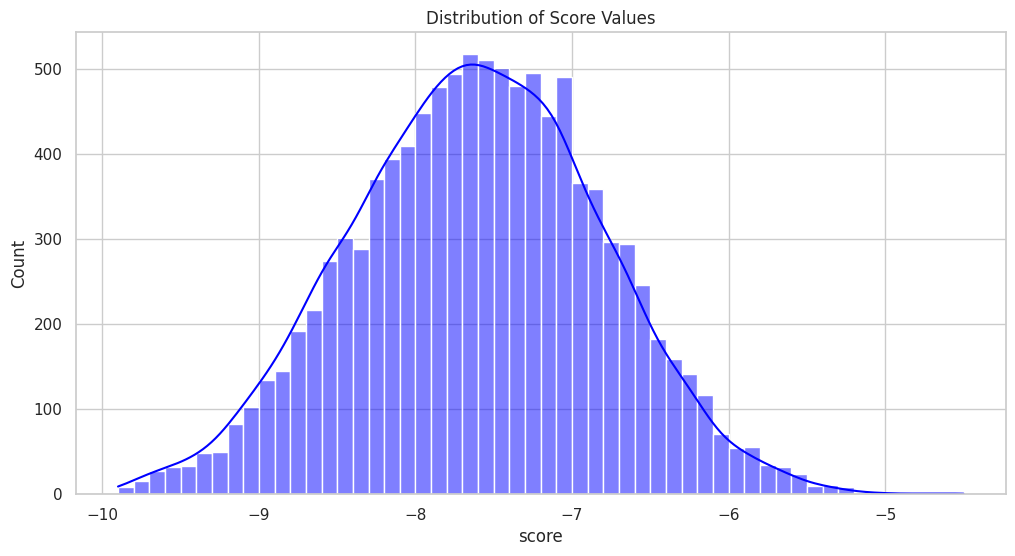

In [ ]:
df = pd.read_csv('/content/molpal/data/Enamine10k_scores.csv.gz')

sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.histplot(df['score'], kde=True, color='blue', binwidth=0.1)
plt.title('Distribution of Score Values')
plt.xlabel('score')
plt.ylabel('Count')
plt.show()

In [ ]:

df_10k = pd.read_csv('Enamine10k_scores.csv.gz')
df_10k.head()

,smiles,score
0,O=C(CCC1CCOC1)N1C[C@H]2CCC[C@@]2(c2nc(-c3ccccc...,-9.9
1,O=C(NCCc1cccc(-c2ccccc2)c1)[C@@H]1CCCCN1,-9.9
2,Cc1ccc(-c2noc(CN3CC=C(c4c[nH]c5ccccc45)CC3)n2)cc1,-9.9
3,O=C(Nc1ccc2c(c1)COC2)[C@H]1CCO[C@@H]1c1ccnn1Cc...,-9.9
4,Cc1nnc([C@]23CCC[C@H]2CN(C(=O)c2cc4[nH]cnc4cc2...,-9.9


Let's create csv with only SMILES for Enamine10k

In [ ]:
%cd /content/molpal/data/
%ls

/content/molpal/data
data_100cluster_of__100.csv  Enamine50k_scores.csv.gz  Second_Enamine10k_scores.csv.gz
Enamine10k_scores.csv.gz     EnamineHTS_pair_umap.npy  Top_0.01_Enamine10k_scores.csv
Enamine10k_smiles.csv.gz     EnamineHTS_scores.csv.gz  top_1per_scores.csv


From there, the selection will be focused on the top 1% of the best performant molecules

In [ ]:
df = pd.read_csv('/content/molpal/data/Enamine10k_scores.csv.gz')

df_sorted = df.sort_values(by='score', ascending=True)

percentile_index = int(len(df_sorted) * 0.01)

top_1per_df = df_sorted.iloc[:percentile_index]

top_1per_df.reset_index(drop=True, inplace=True)

top_1per_df.to_csv('/content/molpal/data/top_1per_scores.csv', index=True)

top_1per_df

,smiles,score
0,O=C(CCC1CCOC1)N1C[C@H]2CCC[C@@]2(c2nc(-c3ccccc...,-9.9
1,O=C(NCCc1cccc(-c2ccccc2)c1)[C@@H]1CCCCN1,-9.9
2,Cc1ccc(-c2noc(CN3CC=C(c4c[nH]c5ccccc45)CC3)n2)cc1,-9.9
3,O=C(Nc1ccc2c(c1)COC2)[C@H]1CCO[C@@H]1c1ccnn1Cc...,-9.9
4,Cc1nnc([C@]23CCC[C@H]2CN(C(=O)c2cc4[nH]cnc4cc2...,-9.9
...,...,...
99,Cc1cc(=O)[nH]cc1C(=O)N1CCCC(c2ccc(F)cc2)CC1,-9.5
100,O=C(CCc1ccc(C(=O)O)cc1)NC1(c2ccccc2)CCC1,-9.5
101,Cc1c(C(=O)N2CCOCC2)nnn1-c1cccc2c1CCN(Cc1ccncc1)C2,-9.5
102,O=C(c1c[nH]nc1[N+](=O)[O-])N1CCC(c2nc(-c3ccncc...,-9.5


### Enamine50k:

In [ ]:
df50k = pd.read_csv("Enamine50k_scores.csv.gz")

df50k.drop(columns=["score"], inplace=True)

df50k.to_csv("Enamine50k_smiles.csv.gz", index=False, columns=["smiles"])

df50k.head()

,smiles
0,Fc1cccc(C2(c3nnc(Cc4cccc5ccccc45)o3)CCOCC2)c1
1,O=C(NCc1ccnc(Oc2ccc(F)cc2)c1)c1[nH]nc2c1CCCC2
2,Cc1ccccc1CC(=O)N1CCN(CC(=O)N2Cc3ccccc3C(c3cccc...
3,O=C(Nc1cc2c(cn1)CCCC2)N1CCCC1c1ccc(O)cc1
4,NC(=O)C1CCN(C(=O)CCc2c(-c3ccc(F)cc3)[nH]c3cccc...


In [ ]:
dfE50 = pd.read_csv('/content/molpal/data/Enamine50k_scores.csv.gz')

dfE50_sorted = dfE50.sort_values(by='score', ascending=True)

percentile_indexE50 = int(len(dfE50_sorted) * 0.01)

top_1per_dfE50 = dfE50_sorted.iloc[:percentile_indexE50]

top_1per_dfE50.reset_index(drop=True, inplace=True)

top_1per_dfE50.to_csv('/content/molpal/data/top_1per_scores.csv', index=True)

top_1per_dfE50

,smiles,score
0,Fc1cccc(C2(c3nnc(Cc4cccc5ccccc45)o3)CCOCC2)c1,-9.9
1,Cc1cnc(-c2cccc(NC(=O)N3CCCC(c4ccnc(N)n4)C3)c2)o1,-9.9
2,COc1ccc(C(=O)N2CCCC2Cc2cccc(F)c2)cc1-n1cnnn1,-9.9
3,CC1(c2cccc3ccccc23)NC(=O)N(Cc2cccc3cccnc23)C1=O,-9.9
4,O=C(c1ccnc(-n2cccn2)c1)N1CCC(Cc2nc3ccccc3[nH]2...,-9.9
...,...,...
492,O=C(Nc1cccc2cccnc12)C1CC(=O)N(Cc2cccc(C(F)(F)F...,-9.6
493,C[C@H](NC(=O)Cn1cnnn1)C(=O)N1CCC=C(c2ccccc2)C1,-9.6
494,O=C(c1ccc(O)cc1)N1CCN(CC(=O)N2CCc3sccc3C2c2ccc...,-9.6
495,O=C(NCC1CCCc2ccccc21)N1CCCN(c2nccs2)CC1,-9.6


### Convert a Databse.csv to a csv.gz

We decided to rename to Database.csv to Enamine10k.csv.gz because Molpal was already preppared to run this file.


In [ ]:


#First, rename the real Enamine10k.csv.gz to REAL_Enaminde10k.csv.gz to ovoid any duplicates

original_filename = "/content/molpal/data/Enaminde10k.csv.gz"
new_filename = "/content/molpal/data/REAL_Enaminde10k.csv.gz"

# Rename the file
os.rename(original_filename, new_filename)

def compress_csv(input_csv_file, output_csv_gz_file):
    with open(input_csv_file, 'rb') as f_in:
        with gzip.open(output_csv_gz_file, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

# Example usage:
#input_csv_file = '/path/to/input_file.csv'
#output_csv_gz_file = '/path/to/output_file.csv.gz'

input_csv_file = '/content/molpal/data/Database_Lucas3_10k.csv'
output_csv_gz_file = '/content/molpal/data/Enamine10k_scores.csv.gz'

compress_csv(input_csv_file, output_csv_gz_file)

In [ ]:
df10k = pd.read_csv("Enamine10k_scores.csv.gz")

df10k.drop(columns=["score"], inplace=True)

df10k.to_csv("Enamine10k_smiles.csv.gz", index=False, columns=["smiles"])

df10k.head()

In [ ]:
df = pd.read_csv('/content/molpal/data/Enamine10k_scores.csv.gz')

df_sorted = df.sort_values(by='score', ascending=True)

percentile_index = int(len(df_sorted) * 0.01)

top_1per_df = df_sorted.iloc[:percentile_index]

top_1per_df.reset_index(drop=True, inplace=True)

top_1per_df.to_csv('/content/molpal/data/top_1per_scores.csv', index=True)

top_1per_df

,smiles,score
0,FC(F)(F)c1cccc(N=Nc2c3oc4ccccc4cc-3c3ccccc23)c1,-10.5
1,Fc1ccc(NN=Cc2c3ccccc3cc3ccccc23)c(F)c1,-10.5
2,Fc1ccc(NN=Cc2c3oc4ccccc4cc-3c3ccccc23)c(F)c1,-10.4
3,FC(F)Oc1ccccc1N=Cc1c2ccccc2cc2ccccc12,-10.2
4,FC(F)(F)Sc1ccc(N=Cc2c3ccccc3cc3ccccc23)cc1,-10.2
...,...,...
95,C1CCCC(OCCN2CCCC2c2nnc3n2CCCCC3)CC1,-8.6
96,NC(=O)C1CCN(C(=O)COC(=O)C2CC(O)CN2C(=O)C23CC4C...,-8.6
97,Cc1noc(C2CCN(c3nc(C)nc4sc5c(c34)CCC5)CC2)n1,-8.6
98,O=C(CNC(=O)C12CC3CC(CC(C3)C1)C2)OCC(=O)N1CCCCCC1,-8.6


###Library Featurization - Fingerprint generation

In [ ]:
%cd /content/molpal/folder_output

/content/molpal/folder_output


### Let's generate of fingerprints for 10k or 50k

In [ ]:
!python /content/molpal/scripts/fingerprints.py -o fps_file --library /content/molpal/data/Enamine10k_smiles.csv.gz  \
--fingerprint pair --length 2048 --radius 2
 # Change the path to /content/molpal/data/Enamine50k_smiles.csv.gz to use Enamine50k anf /content/molpal/data/Enamine10k_smiles.csv.gz to use Enamine50k

2024-05-28 20:11:37,197	INFO worker.py:1740 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
Precalculating fps:   0% 0/32768 [00:00<?, ?batch/s]
Calculating fingerprints:   0% 0/79 [00:00<?, ?chunk/s]
Precalculating fps: 100% 32768/32768 [00:01<00:00, 25205.88batch/s]
Done!
Feature matrix was saved to "fps_file.h5"
When using this fingerprints file, you should add "--fps fps_file.h5 --invalid-lines " to the command line or the config file to speed up pool construction


## Verification that the fps_file create exists

In [ ]:
import os

output_file = "fps_file.h5"
if os.path.exists(output_file):
    print("The file exists.")
else:
    print("The file does not exist.")

The file exists.


#2. MolPAL



## Running MolPAL

### Make sure you are in folder_output

In [12]:
%pwd

'/content/molpal/data'

### Let's define a function to merge all the data generated from the run

In [13]:
def process_and_merge_csvs(csv_score, csv_ucb, csv_std, output_filename):

    df1 = pd.read_csv(csv_score)

    df2 = pd.read_csv(csv_ucb, header=None)
    df2_transposed = df2.T

    df2_transposed.reset_index(drop=True, inplace=True)

    ucb_values = df2_transposed.iloc[:, -1]

    df3 = pd.read_csv(csv_std, header=None)
    df3_transposed = df3.T

    df3_transposed.reset_index(drop=True, inplace=True)

    std_values = df3_transposed.iloc[:, -1]


    df_score_UCB = pd.merge(df1, ucb_values, left_index=True, right_index=True)
    df_score_UCB_dev = pd.merge(df_score_UCB, std_values, left_index=True, right_index=True)


    new_column_names = list(df_score_UCB_dev.columns)
    new_column_names[-2] = 'UCB'
    new_column_names[-1] = 'Std dev'

    df_score_UCB_dev.columns = new_column_names

    df_score_UCB_dev.to_csv(output_filename, index=False)

    print(f"Output saved to {output_filename}")



def selection_fct(csv_all, csv_allselected, output_csv):

    import pandas as pd

    df1 = pd.read_csv(f"{csv_all}")

    df2 = pd.read_csv(f"{csv_allselected}")

    matches = df2[['smiles']].merge(df1.reset_index(), on='smiles', how='inner')

    matched_rows = df1.loc[matches['index']]

    new_df = matched_rows.copy()

    new_df1 = new_df.sort_values(by = 'score', ascending = True)

    return new_df1.to_csv(output_csv, index=False)


### Let's define a function to run molpal with specified parameters, processe the results, and evaluate the fraction of top X% molecules found.

In [14]:
def Molpal_run(model, confid, metrics, init, batches, max_iter, dataset, top_x_perc, k, BETA):

    """
    Runs the molpal tool with specified parameters, processes the results, and evaluates the fraction of top X% molecules found.

    Parameters:
    - model (str): The model to be used by molpal.
    - confid (str): The confidence method to be used.
    - metrics (str): The metric for evaluation.
    - init (int): Initial size of the dataset.
    - batches (int): Batch size for iterations.
    - max_iter (int): Maximum number of iterations.
    - dataset (int): Dataset identifier used to specify the dataset file.
    - top_x_perc (float): The top X percentage of molecules to consider.
    - k (int): Number of top samples to select.
    - BETA (float): Beta parameter for model configuration.

    Functionality:
    1. Runs the molpal tool with the specified parameters, generating intermediate and final output files.
    2. Moves and renames the final output file.
    3. Reads the dataset file and selects the top X% of molecules based on their scores.
    4. Saves the selected top X% molecules to a new file.
    5. Reads the final output file from molpal and finds common molecules with the top X% list.
    6. Prints the fraction of top X% molecules found in the final output.
    7. Processes and merges CSV files.
    8. Performs selection using the specified function.

    Outputs:
    - Prints the fraction of top X% molecules found.
    - Moves and renames output files.
    - Calls additional functions to process and select data.
    """

    !molpal run --write-intermediate --write-final --retrain-from-scratch --library /content/molpal/data/Enamine10k_scores.csv.gz -o lookup --minimize --objective-config /content/molpal/examples/objective/Enamine10k_lookup.ini \
        --model {model} --conf-method {confid} --metric {metrics} --init-size {init} \
        --batch-size {batches} --max-iters {max_iter} --fps /content/molpal/folder_output/fps_file.h5 \
        --output-dir run_output -k {k} --beta {BETA}

    output_filename_csv = f"/content/molpal/folder_output/run_output/all_explored_final_{model}_{metrics}_{init}_{batches}_{max_iter}_beta_{BETA}.csv"
    !mv /content/molpal/folder_output/run_output/all_explored_final.csv {output_filename_csv}

    output_folder_name = f"/content/molpal/folder_output/run_output_{model}_{metrics}_{init}_{batches}_{max_iter}_beta_{BETA}"
    !mv /content/molpal/folder_output/run_output {output_folder_name}

    file_path = f'/content/molpal/data/Enamine{dataset}k_scores.csv.gz'
    df = pd.read_csv(file_path)

    df_sorted = df.sort_values(by='score', ascending=True)

    percentile_index = int(len(df_sorted)* top_x_perc)

    top_x_smiles = df_sorted[['smiles', 'score']].iloc[:percentile_index]

    output_file_path = f'/content/molpal/data/Top_{top_x_perc}_Enamine10k_scores.csv'
    top_x_smiles.to_csv(output_file_path, index=False)

    df_found = pd.read_csv(f"/content/molpal/folder_output/run_output_{model}_{metrics}_{init}_{batches}_{max_iter}_beta_{BETA}/all_explored_final_{model}_{metrics}_{init}_{batches}_{max_iter}_beta_{BETA}.csv")
    df_top_x = pd.read_csv(output_file_path)

    smiles_found = set(df_found['smiles'])
    smiles_top_x = set(df_top_x['smiles'])

    common_smiles = smiles_found.intersection(smiles_top_x)

    num_common_smiles = len(common_smiles)
    print("Fraction of top", top_x_perc*100, " % of smiles found:", num_common_smiles*100 / len(smiles_top_x), "%")


    process_and_merge_csvs(f"/content/molpal/folder_output/run_output_{model}_{metrics}_{init}_{batches}_{max_iter}_beta_{BETA}/all_explored_final_{model}_{metrics}_{init}_{batches}_{max_iter}_beta_{BETA}.csv",
                           f"/content/molpal/folder_output/run_output_{model}_{metrics}_{init}_{batches}_{max_iter}_beta_{BETA}/all_ucb.csv",
                           f"/content/molpal/folder_output/run_output_{model}_{metrics}_{init}_{batches}_{max_iter}_beta_{BETA}/all_std.csv",
                           f"/content/molpal/folder_output/run_output_{model}_{metrics}_{init}_{batches}_{max_iter}_beta_{BETA}/all_data"
                           )

    selection_fct(f"/content/molpal/folder_output/run_output_{model}_{metrics}_{init}_{batches}_{max_iter}_beta_{BETA}/all_data",
                  f"/content/molpal/folder_output/run_output_{model}_{metrics}_{init}_{batches}_{max_iter}_beta_{BETA}/all_explored_final_{model}_{metrics}_{init}_{batches}_{max_iter}_beta_{BETA}.csv",
                  f"/content/molpal/folder_output/run_output_{model}_{metrics}_{init}_{batches}_{max_iter}_beta_{BETA}/all_selected_data"
    )


In [ ]:
def create_combined_csv(smiles_csv_gz_file, fps_h5_file, output_csv_file):
    """
    Reads SMILES and scores from a compressed CSV file, reads fingerprints from an HDF5 file,
    combines the data, and writes the combined data into a new CSV file.

    Parameters:
    - smiles_csv_gz_file (str): Path to the compressed CSV file containing SMILES and scores.
    - fps_h5_file (str): Path to the HDF5 file containing fingerprints.
    - output_csv_file (str): Path to the output CSV file.

    Returns:
    - None
    """

    # Read smiles and scores from the compressed CSV file
    with gzip.open(smiles_csv_gz_file, 'rt') as csvfile:
        reader = csv.reader(csvfile)
        headers = next(reader)  # Read the headers
        if headers != ['smiles', 'score']:
            print("Error: Incorrect headers. The headers must be 'smiles' and 'score'.")
            return
        smiles_scores = [(row[0], row[1]) for row in reader]

    # Read fingerprints from the HDF5 file
    with h5py.File(fps_h5_file, 'r') as h5file:
        fps = h5file['fps'][:]

    # Check if the number of smiles matches the number of fingerprints
    if len(smiles_scores) != len(fps):
        print("Error: Number of smiles and fingerprints don't match")
        return

    # Combine smiles, fps, and scores into a list of rows
    combined_data = [(smiles, *fps_values, score) for (smiles, score), fps_values in zip(smiles_scores, fps)]

    # Write the combined data to a new CSV file
    with open(output_csv_file, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Smiles'] + [f'FP{i}' for i in range(len(fps[0]))] + ['Score'])
        writer.writerows(combined_data)

# Usage example
smiles_score = '/content/molpal/data/Enamine10k_scores.csv.gz'
fps = '/content/molpal/folder_output/fps_file.h5'
create_combined_csv(smiles_score, fps, '/content/molpal/folder_output/smiles_fps_score.csv')

In [ ]:
import pandas as pd
import numpy as np

def Molpal_run(model, confid, metrics, init, batches, max_iter, k, BETA):
    """
    Runs the MolPAL algorithm with specified parameters and saves the results.

    Parameters:
    - model (str): Model to use for the MolPAL run.
    - confid (str): Confidence method.
    - metrics (str): Evaluation metric.
    - init (int): Initial dataset size.
    - batches (int): Batch size for each iteration.
    - max_iter (int): Maximum number of iterations.
    - k (int): Number of neighbors for k-nearest neighbors.
    - BETA (float): Beta parameter for the MolPAL run.

    Returns:
    - None
    """

    !molpal run --write-intermediate --write-final --retrain-from-scratch --library /content/molpal/data/Enamine10k_scores.csv.gz -o lookup --minimize --objective-config /content/molpal/examples/objective/Enamine10k_lookup.ini \
        --model {model} --conf-method {confid} --metric {metrics} --init-size {init} \
        --batch-size {batches} --max-iters {max_iter} --fps /content/molpal/folder_output/fps_file.h5 \
        --output-dir run_output -k {k} --beta {BETA}
    !mv /content/molpal/folder_output/run_output/all_explored_final.csv /content/molpal/folder_output/run_output/all_explored_final_beta_{BETA}.csv
    !mv /content/molpal/folder_output/run_output /content/molpal/folder_output/run_output_beta_{BETA}

def frac_top_x(top_x, csv_file):
    """
    Calculates the fraction of molecules from the selected smiles that are in the top X% of the dataset based on scores.

    Parameters:
    - top_x (int): Number of top molecules to consider.
    - csv_file (str): Path to the CSV file containing the selected smiles.

    Returns:
    - None
    """

    file_path = '/content/molpal/data/Enamine10k_scores.csv.gz'
    df = pd.read_csv(file_path)

    df_sorted = df.sort_values(by='score', ascending=True)

    top_x_smiles = df_sorted[['smiles', 'score']].iloc[:top_x]

    output_file_path = f'/content/molpal/data/Top_{top_x}_Enamine10k_scores.csv'
    top_x_smiles.to_csv(output_file_path, index=False)

    df_found = pd.read_csv(csv_file)
    df_top_x = pd.read_csv(output_file_path)

    smiles_found = set(df_found['smiles'])
    smiles_top_x = set(df_top_x['smiles'])

    common_smiles = smiles_found.intersection(smiles_top_x)

    num_common_smiles = len(common_smiles)
    print("Fraction of top", top_x, "smiles found:", num_common_smiles / len(smiles_top_x))

###Let's define others functions to run molpal with specified parameters, processe the results, and evaluate the fraction of top X% molecules found, and also calculating the Enrichment Factor (EF)

In [16]:
"""
    Parameters:
    - model (str): The model to be used by molpal.
    - confid (str): The confidence method to be used.
    - metrics (str): The metric for evaluation.
    - init (int): Initial size of the dataset.
    - batches (int): Batch size for iterations.
    - max_iter (int): Maximum number of iterations.
    - k (int): Number of top samples to select.
    - BETA (float): Beta parameter for model configuration.
"""

def molpal_run2(model, confid, metrics, init, batches, max_iter, k, BETA):
    """
    Runs the molpal tool with specified parameters and moves the generated output files to appropriate locations.

    Parameters: all listed above molpal_run2

    The function executes molpal with given parameters, renames the final output file, and moves the output directory.
    """

    !molpal run --write-intermediate --write-final --retrain-from-scratch --library /content/molpal/data/Enamine10k_scores.csv.gz -o lookup --minimize --objective-config /content/molpal/examples/objective/Enamine10k_lookup.ini \
        --model {model} --conf-method {confid} --metric {metrics} --init-size {init} \
        --batch-size {batches} --max-iters {max_iter} --fps /content/molpal/folder_output/fps_file.h5 \
        --output-dir run_output -k {k} --beta {BETA}

    output_filename_csv = f"/content/molpal/folder_output/run_output/all_explored_final_{model}_{metrics}_{init}_{batches}_{max_iter}_beta_{BETA}.csv"
    !mv /content/molpal/folder_output/run_output/all_explored_final.csv {output_filename_csv}

    output_folder_name = f"/content/molpal/folder_output/run_output_{model}_{metrics}_{init}_{batches}_{max_iter}_beta_{BETA}"
    !mv /content/molpal/folder_output/run_output {output_folder_name}


def molpal_run_random2(model, confid, init, batches, max_iter, k, BETA):
    """
    Runs the molpal tool with the metric set to random and specified parameters, then moves the generated output files to appropriate locations.

    Parameters: all listed above molpal_run2

    The function executes molpal with given parameters and the metric set to random, renames the final output file, and moves the output directory.
    """

    !molpal run --write-intermediate --write-final --retrain-from-scratch --library /content/molpal/data/Enamine10k_scores.csv.gz -o lookup --minimize --objective-config /content/molpal/examples/objective/Enamine10k_lookup.ini \
        --model {model} --conf-method {confid} --metric random --init-size {init} \
        --batch-size {batches} --max-iters {max_iter} --fps /content/molpal/folder_output/fps_file.h5 \
        --output-dir run_output -k {k} --beta {BETA}

    output_filename_csv = f"/content/molpal/folder_output/run_output/all_explored_final_{model}_random_{init}_{batches}_{max_iter}_beta_{BETA}.csv"
    !mv /content/molpal/folder_output/run_output/all_explored_final.csv {output_filename_csv}

    output_folder_name = f"/content/molpal/folder_output/run_output_{model}_random_{init}_{batches}_{max_iter}_beta_{BETA}"
    !mv /content/molpal/folder_output/run_output {output_folder_name}


def frac_top_x(top_x_perc, dataset, csv_selectedsmiles):
    """
    Calculates the fraction of molecules from the selected smiles that are in the top X% of the dataset based on scores.

    Parameters:
    - top_x_perc (float): The top X percent of the dataset to consider (e.g., 0.1 for top 10%).
    - dataset (int): Dataset identifier used in the file name.
    - csv_selectedsmiles (str): Path to the CSV file containing the selected smiles.

    Returns:
    - float: The fraction of top X% smiles found in the selected smiles.
    """

    file_path = f'/content/molpal/data/Enamine{dataset}k_scores.csv.gz'
    df = pd.read_csv(file_path)

    df_sorted = df.sort_values(by='score', ascending=True)

    percentile_index = int(len(df_sorted) * top_x_perc)

    top_x_smiles = df_sorted[['smiles', 'score']].iloc[:percentile_index]

    output_file_path = f'/content/molpal/data/Top_{top_x_perc}_Enamine10k_scores.csv'
    top_x_smiles.to_csv(output_file_path, index=False)

    df_found = pd.read_csv(csv_selectedsmiles)
    df_top_x = pd.read_csv(f'/content/molpal/data/Top_{top_x_perc}_Enamine10k_scores.csv')

    smiles_found = set(df_found['smiles'])
    smiles_top_x = set(df_top_x['smiles'])

    common_smiles = smiles_found.intersection(smiles_top_x)

    num_common_smiles = len(common_smiles)
    print("Fraction of top", top_x_perc * 100, " % of smiles found:", num_common_smiles * 100 / len(smiles_top_x), "%")

    return num_common_smiles * 100 / len(smiles_top_x)


def experiment_top_ef(model, confid, metrics, init, batches, max_iter, dataset, top_x_perc, k, BETA):
    """
    Runs the molpal tool with specified and random metrics, evaluates the fraction of top X% molecules found, and calculates the Enrichment Factor (EF).

    Parameters: all listed above molpal_run2

    Functionality:
    1. Runs the molpal tool with specified parameters using the provided metric.
    2. Runs the molpal tool with specified parameters using a random metric.
    3. Reads the output files from both runs.
    4. Calculates the fraction of top X% molecules found in each run.
    5. Prints and returns the fraction for both runs and the Enrichment Factor (EF).

    Outputs:
    - Prints the fraction of top X% molecules found for both specified and random metrics.
    - Prints the calculated Enrichment Factor (EF).
    - Returns the fraction for both runs and the EF.

    """

    molpal_run2(model, confid, metrics, init, batches, max_iter, k, BETA)

    molpal_run_random2(model, confid, init, batches, max_iter, k, BETA)

    csv_file_random = f'/content/molpal/folder_output/run_output_{model}_random_{init}_{batches}_{max_iter}_beta_{BETA}/all_explored_final_{model}_random_{init}_{batches}_{max_iter}_beta_{BETA}.csv'
    csv_file = f'/content/molpal/folder_output/run_output_{model}_{metrics}_{init}_{batches}_{max_iter}_beta_{BETA}/all_explored_final_{model}_{metrics}_{init}_{batches}_{max_iter}_beta_{BETA}.csv'

    frac = frac_top_x(top_x_perc, dataset, csv_file)

    frac_random = frac_top_x(top_x_perc, dataset, csv_file_random)

    print("The percentage of molecules recovered from the top", top_x_perc, "% is", frac, "% for", metrics, "and", frac_random, "% for random")
    EF = frac / frac_random

    print("The Enrichment Factor (EF) was calculated to be", EF)

    return frac, EF

### The main function here is experiment_multirun wich can executes multiple runs of molapal if placed in a loop because we added n, a run index. It was used to calculate averages and standard deviations to generate more significant results.

In [17]:
def molpal_run3(model, confid, metrics, init, batches, max_iter, k, BETA, n):
    """
    Runs the molpal tool with specified parameters and saves the output with run index.

    Parameters:
    - model (str): The model to be used by molpal.
    - confid (str): The confidence method to be used.
    - metrics (str): The metric for evaluation.
    - init (int): Initial size of the dataset.
    - batches (int): Batch size for iterations.
    - max_iter (int): Maximum number of iterations.
    - k (int): Number of top samples to select.
    - BETA (float): Beta parameter for UCB.
    - n (int): Run index for identifying multiple runs.

    This function executes molpal with the given parameters, renames the final output file with the run index,
    and moves the output directory to a unique location based on the run index.
    """

    !molpal run --write-intermediate --write-final --retrain-from-scratch --library /content/molpal/data/Enamine10k_scores.csv.gz -o lookup --minimize --objective-config /content/molpal/examples/objective/Enamine10k_lookup.ini \
        --model {model} --conf-method {confid} --metric {metrics} --init-size {init} \
        --batch-size {batches} --max-iters {max_iter} --fps /content/molpal/folder_output/fps_file.h5 \
        --output-dir run_output -k {k} --beta {BETA}

    output_filename_csv = f"/content/molpal/folder_output/run_output/all_explored_final_{model}_{metrics}_{init}_{batches}_{max_iter}_beta_{BETA}_run{n}.csv"
    !mv /content/molpal/folder_output/run_output/all_explored_final.csv {output_filename_csv}

    output_folder_name = f"/content/molpal/folder_output/run_output_{model}_{metrics}_{init}_{batches}_{max_iter}_beta_{BETA}_run{n}"
    !mv /content/molpal/folder_output/run_output {output_folder_name}


def molpal_run_random3(model, confid, init, batches, max_iter, k, BETA, n):
    """
    Runs the molpal tool with random metrics and saves the output with run index.

    Parameters: same as molpal_run3 without metrics, beacasuse we only use random here

    This function executes molpal with random metrics, renames the final output file with the run index,
    and moves the output directory to a unique location based on the run index.
    """

    !molpal run --write-intermediate --write-final --retrain-from-scratch --library /content/molpal/data/Enamine10k_scores.csv.gz -o lookup --minimize --objective-config /content/molpal/examples/objective/Enamine10k_lookup.ini \
        --model {model} --conf-method {confid} --metric random --init-size {init} \
        --batch-size {batches} --max-iters {max_iter} --fps /content/molpal/folder_output/fps_file.h5 \
        --output-dir run_output -k {k} --beta {BETA}

    output_filename_csv = f"/content/molpal/folder_output/run_output/all_explored_final_{model}_random_{init}_{batches}_{max_iter}_beta_{BETA}_run{n}.csv"
    !mv /content/molpal/folder_output/run_output/all_explored_final.csv {output_filename_csv}

    output_folder_name = f"/content/molpal/folder_output/run_output_{model}_random_{init}_{batches}_{max_iter}_beta_{BETA}_run{n}"
    !mv /content/molpal/folder_output/run_output {output_folder_name}


def experiment_multirun(model, confid, metrics, init, batches, max_iter, dataset, top_x_perc, k, BETA, n):
    """
    Executes multiple runs of molpal with specified and random metrics, evaluates the fraction of top X% molecules found, and calculates the Enrichment Factor (EF).

    Parameters:
    - model (str): The model to be used by molpal.
    - confid (str): The confidence method to be used.
    - metrics (str): The metric for evaluation.
    - init (int): Initial size of the dataset.
    - batches (int): Batch size for iterations.
    - max_iter (int): Maximum number of iterations.
    - dataset (int): Dataset identifier used to specify the dataset file.
    - top_x_perc (float): The top X percentage of molecules to consider.
    - k (int): Number of top samples to select.
    - BETA (float): Beta parameter for model configuration.
    - n (int): Run index for identifying multiple runs.

    Functionality:
    1. Runs molpal with specified metrics and saves the output with the run index.
    2. Runs molpal with random metrics and saves the output with the run index.
    3. Reads the output files from both runs.
    4. Calculates the fraction of top X% molecules found in each run.
    5. Prints and returns the fraction for both runs and the Enrichment Factor (EF).

    Outputs:
    - Prints the fraction of top X% molecules found for both specified and random metrics.
    - Prints the calculated Enrichment Factor (EF).
    - Returns the fraction for both runs and the EF.
    """

    # Run molpal with the specified metrics
    molpal_run3(model, confid, metrics, init, batches, max_iter, k, BETA, n)

    # Run molpal with random metrics
    molpal_run_random3(model, confid, init, batches, max_iter, k, BETA, n)

    # Define file paths for the output CSV files
    csv_file_random = f'/content/molpal/folder_output/run_output_{model}_random_{init}_{batches}_{max_iter}_beta_{BETA}_run{n}/all_explored_final_{model}_random_{init}_{batches}_{max_iter}_beta_{BETA}_run{n}.csv'
    csv_file = f'/content/molpal/folder_output/run_output_{model}_{metrics}_{init}_{batches}_{max_iter}_beta_{BETA}_run{n}/all_explored_final_{model}_{metrics}_{init}_{batches}_{max_iter}_beta_{BETA}_run{n}.csv'

    # Calculate the fraction of top X% molecules found for the specified metrics
    frac = frac_top_x(top_x_perc, dataset, csv_file)

    # Calculate the fraction of top X% molecules found for the random metrics
    frac_random = frac_top_x(top_x_perc, dataset, csv_file_random)

    # Print the results
    print("The percentage of molecules recovered from the top", top_x_perc, "% is", frac, "% for", metrics, "and", frac_random, "% for random")

    # Calculate the Enrichment Factor (EF)
    EF = frac / frac_random

    # Print the Enrichment Factor (EF)
    print("The Enrichment Factor (EF) was calculated to be", EF)

    # Return the fractions and the Enrichment Factor (EF)
    return frac, EF


### Experiment_multirun2 is the same as ecperiment_multirun2, without the EF calculation. It has been defined specifically for the study of acquisition functions

In [18]:
def experiment_multirun2(model, confid, metrics, init, batches, max_iter, dataset, top_x_perc, k, BETA, n):
    """
    Executes a single run of molpal with specified metrics and evaluates the fraction of top X% molecules found.

    Parameters: same as experiment_multirun

    Functionality:
    1. Runs molpal with the specified metrics and saves the output with the run index.
    2. Reads the output file from the run.
    3. Calculates the fraction of top X% molecules found.
    4. Prints and returns the fraction of top X% molecules found.

    Outputs:
    - Prints the fraction of top X% molecules found.
    - Returns the fraction of top X% molecules found.
    """

    # Run molpal with the specified metrics
    molpal_run3(model, confid, metrics, init, batches, max_iter, k, BETA, n)

    # Define the file path for the output CSV file
    csv_file = f'/content/molpal/folder_output/run_output_{model}_{metrics}_{init}_{batches}_{max_iter}_beta_{BETA}_run{n}/all_explored_final_{model}_{metrics}_{init}_{batches}_{max_iter}_beta_{BETA}_run{n}.csv'

    # Calculate the fraction of top X% molecules found for the specified metrics
    frac = frac_top_x(top_x_perc, dataset, csv_file)

    # Print the result
    print("The percentage of molecules recovered from the top", top_x_perc, "% is", frac, "% for", metrics)

    # Return the fraction
    return frac


### Experiment_multirun50k is the same as before, it just use Enamine50k instead of Enamine10k.

In [19]:
def molpal_run50k(model, confid, metrics, init, batches, max_iter, k, BETA, n):
    !molpal run --write-intermediate --write-final --retrain-from-scratch --library /content/molpal/data/Enamine50k_scores.csv.gz -o lookup --minimize --objective-config /content/molpal/examples/objective/Enamine50k_lookup.ini \
        --model {model} --conf-method {confid} --metric {metrics} --init-size {init} \
        --batch-size {batches} --max-iters {max_iter} --fps /content/molpal/folder_output/fps_file.h5 \
        --output-dir run_output -k {k} --beta {BETA}

    output_filename_csv = f"/content/molpal/folder_output/run_output/all_explored_final_{model}_{metrics}_{init}_{batches}_{max_iter}_beta_{BETA}_run{n}.csv"
    !mv /content/molpal/folder_output/run_output/all_explored_final.csv {output_filename_csv}

    output_folder_name = f"/content/molpal/folder_output/run_output_{model}_{metrics}_{init}_{batches}_{max_iter}_beta_{BETA}_run{n}"
    !mv /content/molpal/folder_output/run_output {output_folder_name}


def molpal_run_random50k(model, confid, init, batches, max_iter, k, BETA, n):
    !molpal run --write-intermediate --write-final --retrain-from-scratch --library /content/molpal/data/Enamine50k_scores.csv.gz -o lookup --minimize --objective-config /content/molpal/examples/objective/Enamine50k_lookup.ini \
        --model {model} --conf-method {confid} --metric random --init-size {init} \
        --batch-size {batches} --max-iters {max_iter} --fps /content/molpal/folder_output/fps_file.h5 \
        --output-dir run_output -k {k} --beta {BETA}

    output_filename_csv = f"/content/molpal/folder_output/run_output/all_explored_final_{model}_random_{init}_{batches}_{max_iter}_beta_{BETA}_run{n}.csv"
    !mv /content/molpal/folder_output/run_output/all_explored_final.csv {output_filename_csv}

    output_folder_name = f"/content/molpal/folder_output/run_output_{model}_random_{init}_{batches}_{max_iter}_beta_{BETA}_run{n}"
    !mv /content/molpal/folder_output/run_output {output_folder_name}


def experiment_multirun50k(model, confid, metrics, init, batches, max_iter, dataset, top_x_perc, k, BETA, n):

      molpal_run50k(model, confid, metrics, init, batches, max_iter, k, BETA, n)
      #molpal_run_random50k(model, confid, init, batches, max_iter, k, BETA, n)

      #csv_file_random = f'/content/molpal/folder_output/run_output_{model}_random_{init}_{batches}_{max_iter}_beta_{BETA}_run{n}/all_explored_final_{model}_random_{init}_{batches}_{max_iter}_beta_{BETA}_run{n}.csv'
      csv_file = f'/content/molpal/folder_output/run_output_{model}_{metrics}_{init}_{batches}_{max_iter}_beta_{BETA}_run{n}/all_explored_final_{model}_{metrics}_{init}_{batches}_{max_iter}_beta_{BETA}_run{n}.csv'

      frac = frac_top_x(top_x_perc, dataset, csv_file)

      #frac_random = frac_top_x(top_x_perc, dataset, csv_file_random)

      print("The percentage of molecules recovered from the top", top_x_perc, "% is", frac, "% for", metrics)

      #EF = frac/frac_random

     # print("The Enrichement Factor EF was calculated to be", EF)

      #return frac, EF
      return frac

### Tanimoto Similarity functions

In [20]:

class NCircles:
    def __init__(self, threshold=0.75):
        self.sim_mat_func = similarity_matrix_tanimoto
        self.t = threshold

    def get_circles(self, args):
        vecs, sim_mat_func, t = args
        circs = []

        for vec in vecs:
            if len(circs) > 0:
                dists = 1.0 - sim_mat_func([vec], circs)
                if dists.min() <= t:
                    continue
            circs.append(vec)

        return circs

    def measure1(self, vecs, n_chunk=64):
        for i in range(3):
            chunk_size = max(1, n_chunk // (2 ** i))  # Ensure chunk_size is at least 1
            vecs_list = list(mit.chunked(vecs, chunk_size))
            args = zip(vecs_list, [self.sim_mat_func] * len(vecs_list), [self.t] * len(vecs_list))
            circs_list = list(map(self.get_circles, args))
            vecs = [c for ls in circs_list for c in ls]
            random.shuffle(vecs)

        vecs = self.get_circles((vecs, self.sim_mat_func, self.t))
        return len(vecs), vecs  # Ensure measure returns a tuple

    def measure(self, vecs, n_chunk=64):
        for i in range(3):
            vecs_list = list(mit.divide(n_chunk // (2 ** i), vecs))
            args = zip(vecs_list, [self.sim_mat_func] * len(vecs_list), [self.t] * len(vecs_list))
            circs_list = list(map(self.get_circles, args))
            vecs = [c for ls in circs_list for c in ls]
            random.shuffle(vecs)
        vecs = self.get_circles((vecs, self.sim_mat_func, self.t))
        return len(vecs), vecs



def get_ncircle(df):
    if 'FPS' not in df:
        df['FPS'] = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, 1024) for mol in df['MOL']]
    return NCircles().measure(df['FPS'])


def get_ncircle1(df):
    if 'FPS' not in df:
        df['FPS'] = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, 1024) for mol in df['MOL']]
    n_circles, vecs = NCircles().measure(df['FPS'])  # Ensure it returns a tuple
    return n_circles, vecs

def similarity_matrix_tanimoto(fps1, fps2):
    similarities = [BulkTanimotoSimilarity(fp, fps2) for fp in fps1]
    return np.array(similarities)

def average_agg_tanimoto(stock_vecs, gen_vecs,
                         batch_size=5000, agg='max',
                         device='cpu', p=1):
    """
    For each molecule in gen_vecs finds closest molecule in stock_vecs.
    Returns average tanimoto score for between these molecules

    Parameters:
        stock_vecs: numpy array <n_vectors x dim>
        gen_vecs: numpy array <n_vectors' x dim>
        agg: max or mean
        p: power for averaging: (mean x^p)^(1/p)
    """
    assert agg in ['max', 'mean'], "Can aggregate only max or mean"
    agg_tanimoto = np.zeros(len(gen_vecs))
    total = np.zeros(len(gen_vecs))
    for j in range(0, stock_vecs.shape[0], batch_size):
        x_stock = torch.tensor(stock_vecs[j:j + batch_size]).to(device).float()
        for i in range(0, gen_vecs.shape[0], batch_size):
            y_gen = torch.tensor(gen_vecs[i:i + batch_size]).to(device).float()
            y_gen = y_gen.transpose(0, 1)
            tp = torch.mm(x_stock, y_gen)
            jac = (tp / (x_stock.sum(1, keepdim=True) +
                         y_gen.sum(0, keepdim=True) - tp)).cpu().numpy()
            jac[np.isnan(jac)] = 1
            if p != 1:
                jac = jac**p
            if agg == 'max':
                agg_tanimoto[i:i + y_gen.shape[1]] = np.maximum(
                    agg_tanimoto[i:i + y_gen.shape[1]], jac.max(0))
            elif agg == 'mean':
                agg_tanimoto[i:i + y_gen.shape[1]] += jac.sum(0)
                total[i:i + y_gen.shape[1]] += jac.shape[0]
    if agg == 'mean':
        agg_tanimoto /= total
    if p != 1:
        agg_tanimoto = (agg_tanimoto)**(1/p)
    return np.mean(agg_tanimoto)

def smiles_to_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return AllChem.GetMorganFingerprintAsBitVect(mol, 2, 1024)
    else:
        return None

def bitvect_to_list(bitvect):
    return [int(bitvect.GetBit(i)) for i in range(bitvect.GetNumBits())]

### Visualizing and determining the optimal number of clusters for molecular  using nCircles and PCA

In [22]:
def plot_circles1(df, n_cluster):

    """
    This script provides functions for visualizing and determining the optimal number of clusters for molecular data.
    The steps include:

    1. **plot_circles1(df, n_cluster)**:
    - Unpack the number of circles and vectors from the dataset.
    - Convert molecular fingerprints to a numpy array.
    - Perform K-Means clustering on the data.
    - Use PCA to reduce the data to 2 dimensions.
    - Plot the reduced data with cluster labels for visual inspection.

    2. **elbow_method(data, max_k)**:
    - Compute the Sum of Squared Errors (SSE) for a range of cluster numbers.
    - Plot the SSE against the number of clusters to use the Elbow Method for determining the optimal number of clusters.
    """
    n_circles, vecs = get_ncircle1(df)  # Properly unpack the returned tuple
    print(f'Number of circles: {n_circles}')

    # Convert fingerprints to numpy array
    vecs_array = np.array([bitvect_to_list(fp) for fp in vecs])

    # Perform K-Means clustering
    kmeans = KMeans(n_clusters=n_cluster, random_state=42)
    cluster_labels = kmeans.fit_predict(vecs_array)

    # Perform PCA to reduce dimensions to 2
    pca = PCA(n_components=2)
    reduced_vecs = pca.fit_transform(vecs_array)

    # Plot the reduced vectors with cluster labels
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced_vecs[:, 0], reduced_vecs[:, 1], c=cluster_labels, cmap='viridis', marker='o')
    plt.title('Chemical Space 2D Plot of Circles with Clusters')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.grid(True)
    plt.legend(*scatter.legend_elements(), title="Clusters")
    plt.show()

def elbow_method(data, max_k):
    iters = range(1, max_k+1, 1)
    sse = []

    for k in iters:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        sse.append(kmeans.inertia_)  # WCSS

    plt.figure(figsize=(10, 8))
    plt.plot(iters, sse, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Sum of squared distances (WCSS)')
    plt.title('Elbow Method for Optimal Number of Clusters')
    plt.grid(True)
    plt.show()

# 3. Analysis of data and active learning improvement studies

The objective was to optimise each parameter provided by the users in order to obtain the best fractions of the top X%. To achieve this, various experiments were performed.

##3.1 UCB vs Score correlation plot

In the aim of finding way to leverage active learning, it was decided to firstly observe the effects of varying batch size (batch size) and number of iterations (iters) with a constant initialization batch size set at 1% of the total dataset size (10k molecules)

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


run_nbr = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

array_frac_100_rf = []
array_EF_rf = []
list_of_lists_100 = []
list_of_lists_EF = []

#First run
#max_iter = [50,25,20,10,6,5,4,2]
#batches = [10,20,25,50,83,100,125,250]

max_iter = [50,25,20]
batches = [10,20,25]



for i in range(len(batches)):

  for j in range(len(run_nbr)):

    frac = experiment_multirun2('rf', 'mve', 'ucb', 100, batches[i], max_iter[i], 10, 0.01, 1000, 2, run_nbr[j])
    array_frac_100_rf.append(frac)
    #array_EF_rf.append(EF)

  list_of_lists_100.append([array_frac_100_rf])
 # list_of_lists_EF.append([array_EF_rf])

  array_frac_100_rf = []
 # array_EF_rf = []


#average_EF = [np.mean(values) for values in list_of_lists_EF]
#std_devs_EF = [np.std(values) for values in list_of_lists_EF]

average_100 = [np.mean(values) for values in list_of_lists_100]
std_devs_100 = [np.std(values) for values in list_of_lists_100]

***********************************************************************
*   __    __     ______     __         ______   ______     __         *
*  /\ "-./  \   /\  __ \   /\ \       /\  == \ /\  __ \   /\ \        *
*  \ \ \-./\ \  \ \ \/\ \  \ \ \____  \ \  _-/ \ \  __ \  \ \ \____   *
*   \ \_\ \ \_\  \ \_____\  \ \_____\  \ \_\    \ \_\ \_\  \ \_____\  *
*    \/_/  \/_/   \/_____/   \/_____/   \/_/     \/_/\/_/   \/_____/  *
*                                                                     *
***********************************************************************
Welcome to MolPAL!
MolPAL will be run with the following arguments:
  batch_sizes: [10]
  beta: 2
  budget: 1.0
  cache: False
  checkpoint_file: None
  chkpt_freq: 0
  cluster: False
  config: None
  cxsmiles: False
  delimiter: ,
  delta: 0.01
  epsilon: 0.0
  fingerprint: pair
  fps: /content/molpal/folder_output/fps_file.h5
  init_size: 100
  invalid_idxs: None
  k: 1000
  length: 2048
  libraries: ['/content/molpal/

FileNotFoundError: [Errno 2] No such file or directory: '/content/molpal/folder_output/run_output_rf_ucb_100_20_25_beta_2_run1/all_explored_final_rf_ucb_100_20_25_beta_2_run1.csv'

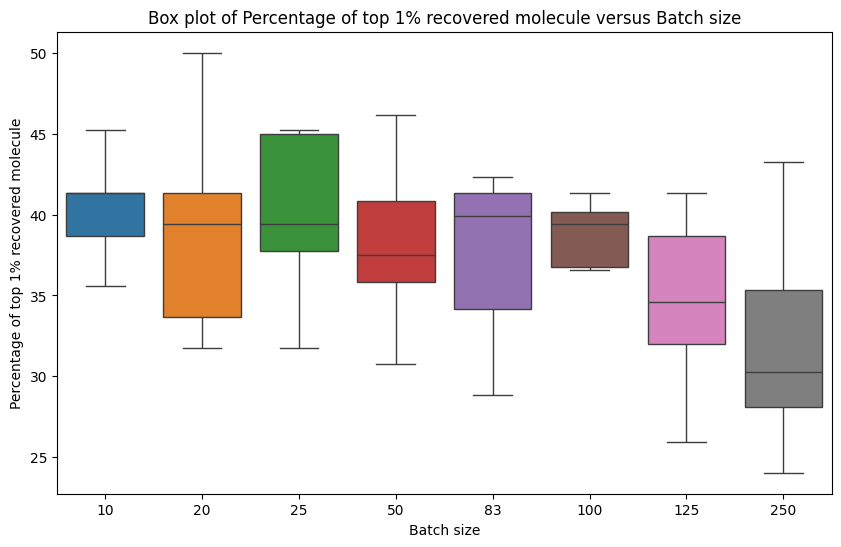

In [ ]:
import pandas as pd
from io import StringIO

#Plot Percentage of top 1% recovered for Enamine10k

#Plot bas 10 to 250 for Enamine10k

# Text data
data = """10 20 25 50 83 100 125 250
45.192308 32.692308 45.192308 45.192308 42.307692 41.346154 34.615385 50.000000
39.423077 38.461538 31.730769 36.538462 32.692308 36.538462 40.384615 35.576923
41.346154 42.307692 37.500000 36.538462 32.692308 37.500000 39.423077 31.730769
41.346154 32.692308 36.538462 30.769231 39.423077 39.423077 31.730769 24.038462
38.461538 36.538462 45.192308 39.423077 38.461538 39.423077 26.923077 28.846154
41.346154 40.384615 45.192308 35.576923 42.307692 45.192308 25.961538 28.846154
41.346154 50.000000 39.423077 46.153846 28.846154 39.423077 32.692308 34.615385
37.500000 31.730769 38.461538 38.461538 41.346154 31.730769 41.346154 24.038462
42.307692 41.346154 39.423077 34.615385 41.346154 36.538462 36.538462 43.269231
35.576923 41.346154 44.230769 41.346154 40.384615 40.384615 34.615385 27.884615"""


# Use StringIO to convert the string data to a file-like object
data = StringIO(data)

# Read the data into a DataFrame
df_100 = pd.read_csv(data, sep=" ")

#df_list_of_lists_EF_inverted.columns = ['0', '100','200', '300', '400', '500']
df_100.columns = ["10","20","25","50","83","100","125","250"]
df_100.index = df_100.index + 1
df_100

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_100, showfliers=False)

plt.title('Box plot of Percentage of top 1% recovered molecule versus Batch size')
plt.ylabel('Percentage of top 1% recovered molecule')
plt.xlabel('Batch size')

plt.show()

In [ ]:
import pandas as pd
from io import StringIO

#Plot EF for Enamine10k

# Text data
data = """10 20 25 50 83 100 125 250
6.714286 3.400000 6.714286 15.666667 8.800000 7.166667 4.000000 5.777778
5.857143 10.000000 8.250000 5.428571 4.857143 5.428571 4.200000 18.500000
7.166667 7.333333 39.000000 6.333333 5.666667 6.500000 5.857143 8.250000
10.750000 6.800000 9.500000 5.333333 3.727273 13.666667 8.250000 3.571429
6.666667 4.750000 6.714286 10.250000 5.714286 6.833333 4.000000 5.000000
7.166667 4.666667 6.714286 6.166667 7.333333 5.875000 5.400000 2.727273
6.142857 10.400000 6.833333 8.000000 4.285714 5.125000 4.857143 12.000000
6.500000 8.250000 10.000000 8.000000 8.600000 5.500000 4.777778 3.571429
8.800000 4.777778 5.125000 6.000000 5.375000 12.666667 4.750000 6.428571
6.166667 8.600000 9.200000 4.300000 7.000000 5.250000 9.000000 9.666667"""


# Use StringIO to convert the string data to a file-like object
data_EF = StringIO(data)

# Read the data into a DataFrame
df_EF = pd.read_csv(data_EF, sep=" ")

#df_list_of_lists_EF_inverted.columns = ['0', '100','200', '300', '400', '500']
df_EF.columns = ["10","20","25","50","83","100","125","250"]
df_EF .index = df_EF.index + 1


plt.figure(figsize=(10, 6))
sns.boxplot(data=df_EF , showfliers=False)

plt.title('Box plot of EF Values versus Batch size')
plt.ylabel('EF Values')
plt.xlabel('Batch size')

plt.show()

##3.2 Effect of the initialization size



###3.2.1 Initialization size and Batch size

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


run_nbr = [1 ,2, 3, 4, 5, 6, 7, 8, 9, 10]


array_frac_100_rf = []
array_EF_rf = []
list_of_lists_100 = []
list_of_lists_EF = []

ini = [1, 100, 200, 300, 400, 500]
batches = [120,100,80,60,40,20]




for i in range(len(ini)):

  for j in range(len(run_nbr)):

    frac = experiment_multirun2('rf', 'mve', 'ucb', ini[i], batches[i], 5, 10, 0.01, 1000, 2, run_nbr[j])
    array_frac_100_rf.append(frac)
    #array_EF_rf.append(EF)

  list_of_lists_100.append([array_frac_100_rf])
  #list_of_lists_EF.append([array_EF_rf])

  array_frac_100_rf = []
  #array_EF_rf = []


#average_EF = [np.mean(values) for values in list_of_lists_EF]
#std_devs_EF = [np.std(values) for values in list_of_lists_EF]

average_100 = [np.mean(values) for values in list_of_lists_100]
std_devs_100 = [np.std(values) for values in list_of_lists_100]

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  scores_csvs: None
  seed: None
  smiles_col: 0
  test_batch_size: None
  title_line: True
  verbose: 0
  window_size: 3
  write_final: True
  write_intermediate: True

2024-05-27 20:16:27,932	INFO worker.py:1740 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
Ray cluster online with resources:
{'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0, 'object_store_memory': 16339431014.0, 'memory': 32678862030.0, 'CPU': 8.0}

Validating: 10449it [00:02, 4397.58it/s]
Starting exploration...
ITER: 0/5 | TOP-1000 AVE: N/A (no scores) | BUDGET: 0/10449.
Acquiring: 100% 10449/10449 [00:00<00:00, 408754.81it/s]
ITER: 1/5 | TOP-1000 AVE: 7.200 (only 1 scores) | BUDGET: 1/10449. Continuing...
2024-05-27 20:16:36,250	WARNING pool.py:589 -- The 'context' argument is not supported using ray. Please refer to the documentation for how to control ray initialization.
Inference: 100% 1/1 [00:02<00:00, 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Flatten the list of lists
flat_data_100 = [inner_list[0] for inner_list in list_of_lists_100]

# Create a DataFrame with each sublist as a separate column
df_list_of_lists_100_inverted = pd.DataFrame(flat_data_100).T

# Rename the columns if needed
df_list_of_lists_100_inverted.columns = [f'Column {i+1}' for i in range(len(df_list_of_lists_100_inverted.columns))]


df_list_of_lists_100_inverted.columns = ['1', '100','200', '300', '400', '500']
df_list_of_lists_100_inverted.index = df_list_of_lists_100_inverted.index + 1
df_list_of_lists_100_inverted

# Box plot Top X

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_list_of_lists_100_inverted, showfliers=False)

plt.title('Box plot of Percentage of top 1% recovered moleculeversus Initialization size')
plt.ylabel('Percentage of top 1% recovered molecule')
plt.xlabel('Initialization size')

plt.show()

In [ ]:
df_list_of_lists_100_inverted

,1,100,200,300,400,500
1,35.576923,44.230769,39.423077,25.000000,25.000000,12.500000
2,25.961538,28.846154,26.923077,36.538462,26.923077,14.423077
3,34.615385,42.307692,31.730769,24.038462,25.000000,19.230769
4,32.692308,41.346154,24.038462,25.961538,27.884615,14.423077
5,38.461538,35.576923,32.692308,27.884615,14.423077,13.461538
6,33.653846,45.192308,22.115385,30.769231,16.346154,13.461538
7,35.576923,39.423077,39.423077,24.038462,22.115385,9.615385
8,36.538462,40.384615,32.692308,31.730769,26.923077,19.230769
9,25.961538,42.307692,27.884615,29.807692,19.230769,11.538462
10,33.653846,33.653846,35.576923,22.115385,23.076923,12.500000


###3.2.2 Initialization size and Iters

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


run_nbr = [1 ,2, 3, 4, 5, 6, 7, 8, 9, 10]


array_frac_100_rf = []
array_EF_rf = []
list_of_lists_100 = []
list_of_lists_EF = []

ini = [1, 100, 200, 300, 400, 500]
iters = [6, 5 4, 3 ,2, 1]




for i in range(len(ini)):

  for j in range(len(run_nbr)):

    frac = experiment_multirun2('rf', 'mve', 'ucb', ini[i], 100, iters[i], 10, 0.01, 1000, 2, run_nbr[j])
    array_frac_100_rf.append(frac)
    #array_EF_rf.append(EF)

  list_of_lists_100.append([array_frac_100_rf])
 #list_of_lists_EF.append([array_EF_rf])

  array_frac_100_rf = []
  #array_EF_rf = []


#average_EF = [np.mean(values) for values in list_of_lists_EF]
#std_devs_EF = [np.std(values) for values in list_of_lists_EF]

average_100 = [np.mean(values) for values in list_of_lists_100]
std_devs_100 = [np.std(values) for values in list_of_lists_100]

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  output_dir: run_output
  pool: eager
  previous_scores: None
  prune: False
  radius: 2
  retrain_from_scratch: True
  scores_csvs: None
  seed: None
  smiles_col: 0
  test_batch_size: None
  title_line: True
  verbose: 0
  window_size: 3
  write_final: True
  write_intermediate: True

2024-05-27 21:19:53,422	INFO worker.py:1740 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
Ray cluster online with resources:
{'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0, 'memory': 32672400999.0, 'object_store_memory': 16336200499.0, 'CPU': 8.0}

Validating: 10449it [00:02, 4995.76it/s]
Starting exploration...
ITER: 0/6 | TOP-1000 AVE: N/A (no scores) | BUDGET: 0/10449.
Acquiring: 100% 10449/10449 [00:00<00:00, 456923.58it/s]
ITER: 1/6 | TOP-1000 AVE: 6.700 (only 1 scores) | BUDGET: 1/10449. Continuing...
2024-05-27 21:20:01,033	WARNING pool.py:589 -- The 'context' argument is not supported

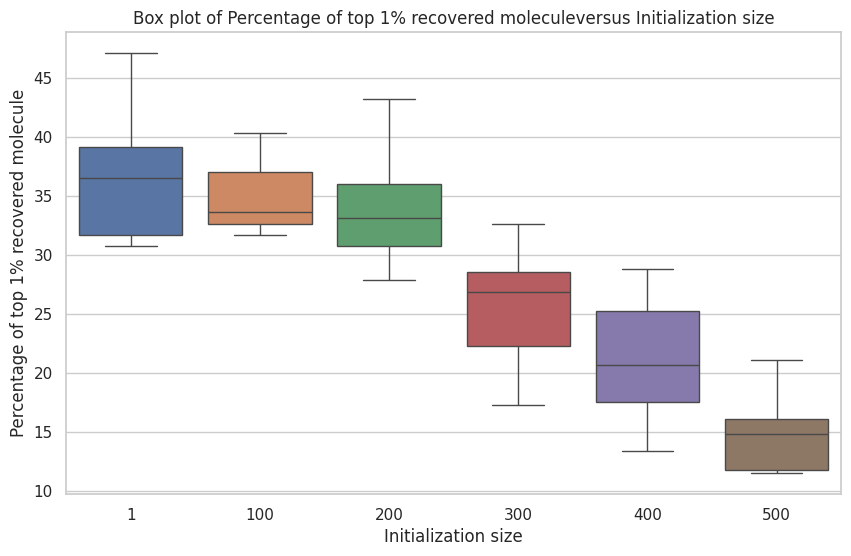

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Flatten the list of lists
flat_data_100 = [inner_list[0] for inner_list in list_of_lists_100]

# Create a DataFrame with each sublist as a separate column
df_list_of_lists_100_inverted = pd.DataFrame(flat_data_100).T

# Rename the columns if needed
df_list_of_lists_100_inverted.columns = [f'Column {i+1}' for i in range(len(df_list_of_lists_100_inverted.columns))]


df_list_of_lists_100_inverted.columns = ['1', '100','200', '300', '400', '500']
df_list_of_lists_100_inverted.index = df_list_of_lists_100_inverted.index + 1
df_list_of_lists_100_inverted

# Box plot Top X

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_list_of_lists_100_inverted, showfliers=False)

plt.title('Box plot of Percentage of top 1% recovered moleculeversus Initialization size')
plt.ylabel('Percentage of top 1% recovered molecule')
plt.xlabel('Initialization size')

plt.show()

In [ ]:
df_list_of_lists_100_inverted

,1,100,200,300,400,500
1,30.769231,31.730769,34.615385,17.307692,14.423077,17.307692
2,47.115385,33.653846,27.884615,32.692308,23.076923,21.153846
3,30.769231,32.692308,30.769231,23.076923,17.307692,15.384615
4,35.576923,37.500000,31.730769,27.884615,21.153846,16.346154
5,38.461538,40.384615,34.615385,22.115385,26.923077,14.423077
6,31.730769,35.576923,30.769231,21.153846,20.192308,11.538462
7,39.423077,21.153846,37.500000,27.884615,13.461538,12.500000
8,44.230769,32.692308,36.538462,25.961538,28.846154,15.384615
9,37.500000,39.423077,43.269231,28.846154,18.269231,11.538462
10,31.730769,33.653846,28.846154,28.846154,25.961538,11.538462


##3.3 UCB and Beta

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


run_nbr = [1 ,2, 3, 4, 5, 6 ,7 ,8 ,9 ,10]

beta = [0, 1, 2, 3, 4, 5]


array_frac_100_rf = []
array_EF_rf = []
list_of_lists_100 = []
list_of_lists_EF = []


for i in range(len(beta)):

  for j in range(len(run_nbr)):

    #def experiment_multirun(model, confid, metrics, init, batches, max_iter, dataset, top_x_perc, k, BETA, n):
    frac = experiment_multirun2('rf', 'mve', 'ucb', 100, 100, 5, 10, 0.01, 1000, beta[i], run_nbr[j])
    array_frac_100_rf.append(frac)
    #array_EF_rf.append(EF)

  list_of_lists_100.append([array_frac_100_rf])
 # list_of_lists_EF.append([array_EF_rf])

  array_frac_100_rf = []
  #array_EF_rf = []


#average_EF = [np.mean(values) for values in list_of_lists_EF]
#std_devs_EF = [np.std(values) for values in list_of_lists_EF]

average_100 = [np.mean(values) for values in list_of_lists_100]
std_devs_100 = [np.std(values) for values in list_of_lists_100]

***********************************************************************
*   __    __     ______     __         ______   ______     __         *
*  /\ "-./  \   /\  __ \   /\ \       /\  == \ /\  __ \   /\ \        *
*  \ \ \-./\ \  \ \ \/\ \  \ \ \____  \ \  _-/ \ \  __ \  \ \ \____   *
*   \ \_\ \ \_\  \ \_____\  \ \_____\  \ \_\    \ \_\ \_\  \ \_____\  *
*    \/_/  \/_/   \/_____/   \/_____/   \/_/     \/_/\/_/   \/_____/  *
*                                                                     *
***********************************************************************
Welcome to MolPAL!
MolPAL will be run with the following arguments:
  batch_sizes: [100]
  beta: 0
  budget: 1.0
  cache: False
  checkpoint_file: None
  chkpt_freq: 0
  cluster: False
  config: None
  cxsmiles: False
  delimiter: ,
  delta: 0.01
  epsilon: 0.0
  fingerprint: pair
  fps: /content/molpal/folder_output/fps_file.h5
  init_size: 100
  invalid_idxs: None
  k: 1000
  length: 2048
  libraries: ['/content/molpal

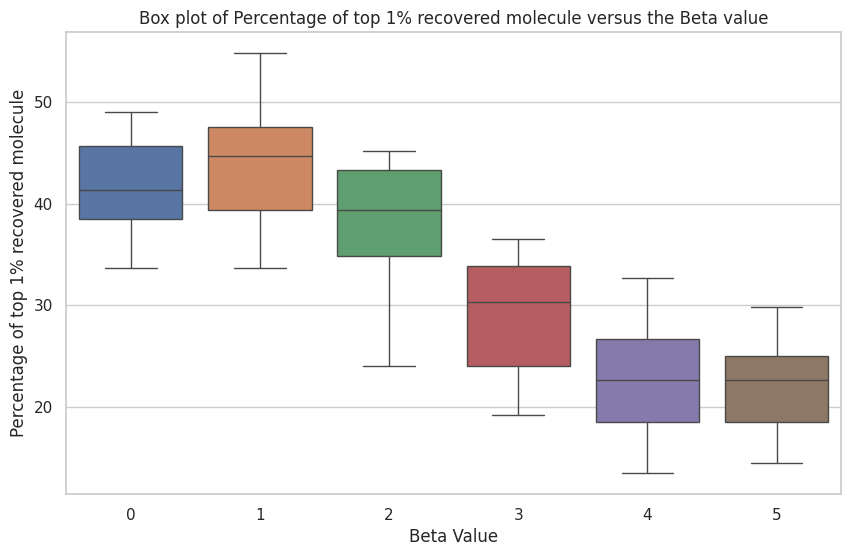

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

list_of_lists_100

# Flatten the list of lists
flat_data_100 = [inner_list[0] for inner_list in list_of_lists_100]

# Create a DataFrame with each sublist as a separate column
df_list_of_lists_100_inverted = pd.DataFrame(flat_data_100).T

# Rename the columns if needed
df_list_of_lists_100_inverted.columns = [f'Column {i+1}' for i in range(len(df_list_of_lists_100_inverted.columns))]

#Need to change the names of the collumns depending on the experimental Initialization size

df_list_of_lists_100_inverted.columns = ['0', '1','2', '3', '4', '5']
df_list_of_lists_100_inverted.index = df_list_of_lists_100_inverted.index + 1
df_list_of_lists_100_inverted

# Box plot Top X

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_list_of_lists_100_inverted, showfliers=False)

plt.title('Box plot of Percentage of top 1% recovered molecule versus the Beta value')
plt.ylabel('Percentage of top 1% recovered molecule')
plt.xlabel('Beta Value')

plt.show()

In [ ]:
#To copy the dataframe if we need it later
df_list_of_lists_100_inverted

,0,1,2,3,4,5
1,43.269231,43.269231,34.615385,19.230769,23.076923,25.000000
2,48.076923,48.076923,25.000000,34.615385,13.461538,29.807692
3,39.423077,46.153846,35.576923,28.846154,19.230769,18.269231
4,38.461538,34.615385,24.038462,24.038462,26.923077,22.115385
5,38.461538,39.423077,43.269231,35.576923,25.961538,23.076923
6,46.153846,46.153846,36.538462,24.038462,22.115385,8.653846
7,33.653846,54.807692,43.269231,31.730769,16.346154,25.000000
8,44.230769,39.423077,45.192308,36.538462,32.692308,19.230769
9,38.461538,33.653846,42.307692,19.230769,18.269231,26.923077
10,49.038462,48.076923,43.269231,31.730769,30.769231,14.423077


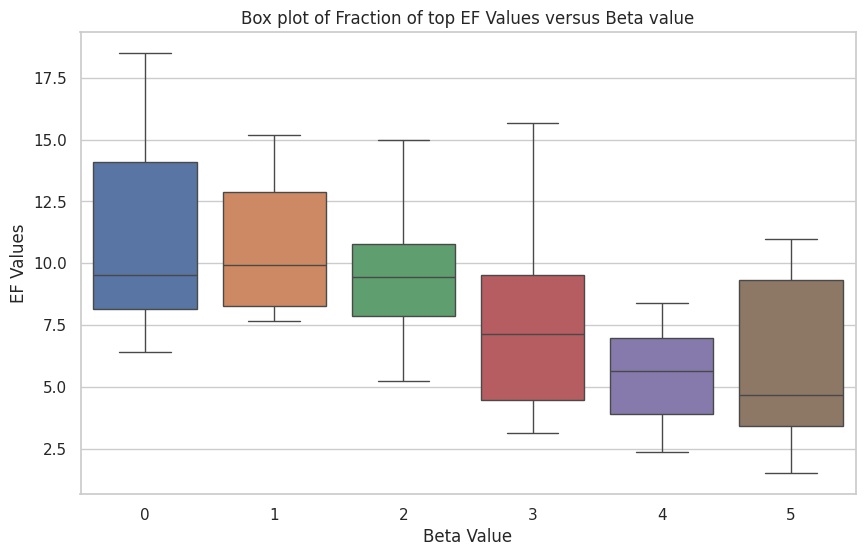

In [ ]:
# Box plot EF

# Flatten the list of lists
flat_data_EF = [inner_list[0] for inner_list in list_of_lists_EF]

# Create a DataFrame with each sublist as a separate column
df_list_of_lists_EF_inverted = pd.DataFrame(flat_data_EF).T

# Rename the columns if needed
df_list_of_lists_EF_inverted.columns = [f'Column {i+1}' for i in range(len(df_list_of_lists_EF_inverted.columns))]
'''
Need to change the names of the collumns depending on the experimental Initialization size
'''
df_list_of_lists_EF_inverted.columns = ['0', '1','2', '3', '4', '5']
df_list_of_lists_EF_inverted.index = df_list_of_lists_EF_inverted.index + 1
df_list_of_lists_EF_inverted

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_list_of_lists_EF_inverted, showfliers=False)

plt.title('Box plot of Fraction of top EF Values versus Beta value')
plt.ylabel('EF Values')
plt.xlabel('Beta Value')

plt.show()

## 3.4 Effect of the Aquirer on the active learning performance


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


run_nbr = [1 ,2, 3, 4, 5, 6, 7, 8, 9, 10 ]
array_frac_100_rf = []
array_EF_rf = []
list_of_lists_100 = []
list_of_lists_EF = []

aquirer = ['random', 'ei', 'greedy', 'pi', 'ts', 'ucb', 'thompson']


for i in range(len(aquirer)):

  for j in range(len(run_nbr)):
    frac = experiment_multirun2('rf', 'mve', aquirer[i], 100, 100, 5, 10, 0.01, 1000, 1, run_nbr[j])
    array_frac_100_rf.append(frac)


  list_of_lists_100.append([array_frac_100_rf])
  array_frac_100_rf = []

average_100 = [np.mean(values) for values in list_of_lists_100]
std_devs_100 = [np.std(values) for values in list_of_lists_100]

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Fraction of top 1.0  % of smiles found: 30.76923076923077 %
The percentage of molecules recovered from the top 0.01 % is 30.76923076923077 % for ei
***********************************************************************
*   __    __     ______     __         ______   ______     __         *
*  /\ "-./  \   /\  __ \   /\ \       /\  == \ /\  __ \   /\ \        *
*  \ \ \-./\ \  \ \ \/\ \  \ \ \____  \ \  _-/ \ \  __ \  \ \ \____   *
*   \ \_\ \ \_\  \ \_____\  \ \_____\  \ \_\    \ \_\ \_\  \ \_____\  *
*    \/_/  \/_/   \/_____/   \/_____/   \/_/     \/_/\/_/   \/_____/  *
*                                                                     *
***********************************************************************
Welcome to MolPAL!
MolPAL will be run with the following arguments:
  batch_sizes: [100]
  budget: 1.0
  cache: False
  checkpoint_file: None
  chkpt_freq: 0
  cluster: False
  config: None
  cxsmil

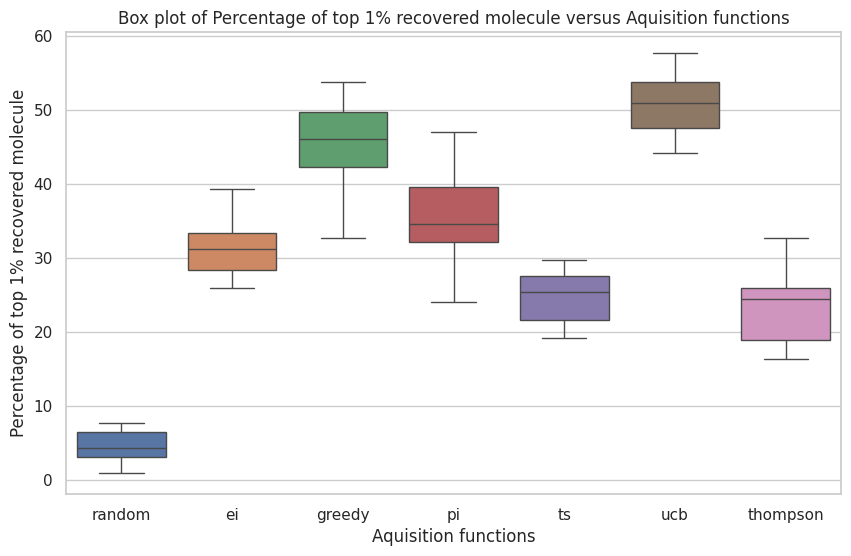

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

list_of_lists_100

# Flatten the list of lists
flat_data_100 = [inner_list[0] for inner_list in list_of_lists_100]

# Create a DataFrame with each sublist as a separate column
df_list_of_lists_100_inverted = pd.DataFrame(flat_data_100).T

# Rename the columns if needed
df_list_of_lists_100_inverted.columns = [f'Column {i+1}' for i in range(len(df_list_of_lists_100_inverted.columns))]

#Need to change the names of the collumns depending on the experimental Initialization size

df_list_of_lists_100_inverted.columns = ['random', 'ei', 'greedy', 'pi', 'ts', 'ucb', 'thompson']
df_list_of_lists_100_inverted.index = df_list_of_lists_100_inverted.index + 1
df_list_of_lists_100_inverted

# Box plot Top X

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_list_of_lists_100_inverted, showfliers=False)

plt.title('Box plot of Percentage of top 1% recovered molecule versus Aquisition functions')
plt.ylabel('Percentage of top 1% recovered molecule')
plt.xlabel('Aquisition functions')

plt.show()

In [ ]:
df_list_of_lists_100_inverted

,random,ei,greedy,pi,ts,ucb,thompson
1,7.692308,32.692308,44.230769,33.653846,23.076923,47.115385,21.153846
2,5.769231,30.769231,50.000000,47.115385,26.923077,53.846154,25.961538
3,2.884615,44.230769,32.692308,42.307692,21.153846,44.230769,18.269231
4,6.730769,20.192308,50.000000,31.730769,28.846154,53.846154,32.692308
5,4.807692,29.807692,41.346154,24.038462,19.230769,55.769231,27.884615
6,2.884615,31.730769,49.038462,40.384615,27.884615,57.692308,17.307692
7,0.961538,25.961538,48.076923,29.807692,25.961538,50.000000,25.000000
8,7.692308,27.884615,53.846154,33.653846,29.807692,51.923077,25.961538
9,3.846154,39.423077,42.307692,35.576923,25.000000,49.038462,16.346154
10,3.846154,33.653846,42.307692,37.500000,19.230769,36.538462,24.038462


# Enamine50K

As the number of iterations was much greater for 50k than for 10k, each run was made separately in the first step and plotted in the second.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


run_nbr = [1]
beta = [0, 1, 2, 3, 4, 5]


array_frac_100_rf = []
array_EF_rf = []
list_of_lists_100 = []
list_of_lists_EF = []


for i in range(len(beta)):

  for j in range(len(run_nbr)):

    #def experiment_multirun(model, confid, metrics, init, batches, max_iter, dataset, top_x_perc, k, BETA, n):
    frac = experiment_multirun50k('rf', 'mve', 'ucb', 500, 224, 11, 50, 0.01, 3500, beta[i], run_nbr[j])
    array_frac_100_rf.append(frac)
    #array_EF_rf.append(EF)

  list_of_lists_100.append([array_frac_100_rf])
 # list_of_lists_EF.append([array_EF_rf])

  array_frac_100_rf = []
  #array_EF_rf = []


#average_EF = [np.mean(values) for values in list_of_lists_EF]
#std_devs_EF = [np.std(values) for values in list_of_lists_EF]

average_100 = [np.mean(values) for values in list_of_lists_100]
std_devs_100 = [np.std(values) for values in list_of_lists_100]

***********************************************************************
*   __    __     ______     __         ______   ______     __         *
*  /\ "-./  \   /\  __ \   /\ \       /\  == \ /\  __ \   /\ \        *
*  \ \ \-./\ \  \ \ \/\ \  \ \ \____  \ \  _-/ \ \  __ \  \ \ \____   *
*   \ \_\ \ \_\  \ \_____\  \ \_____\  \ \_\    \ \_\ \_\  \ \_____\  *
*    \/_/  \/_/   \/_____/   \/_____/   \/_/     \/_/\/_/   \/_____/  *
*                                                                     *
***********************************************************************
Welcome to MolPAL!
MolPAL will be run with the following arguments:
  batch_sizes: [224]
  beta: 0
  budget: 1.0
  cache: False
  checkpoint_file: None
  chkpt_freq: 0
  cluster: False
  config: None
  cxsmiles: False
  delimiter: ,
  delta: 0.01
  epsilon: 0.0
  fingerprint: pair
  fps: /content/molpal/folder_output/fps_file.h5
  init_size: 500
  invalid_idxs: None
  k: 3500
  length: 2048
  libraries: ['/content/molpal

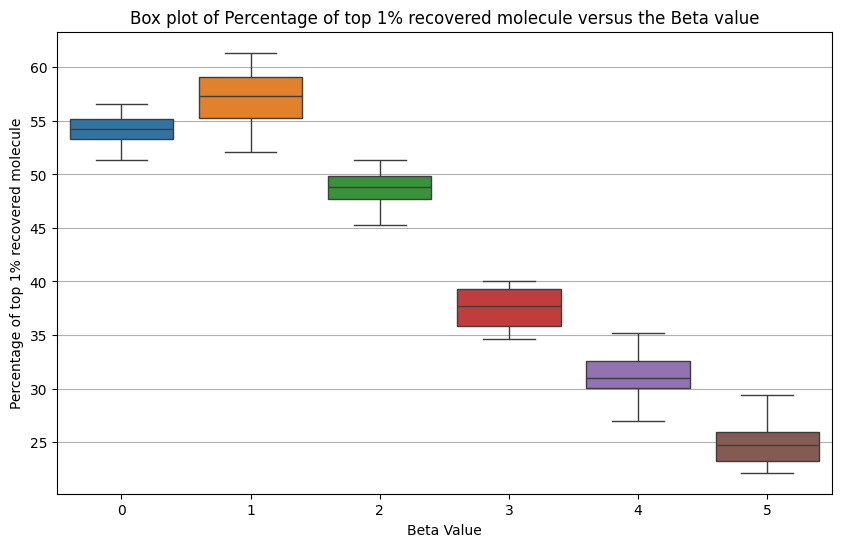

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

list_of_lists_100

# Flatten the list of lists
flat_data_100 = [inner_list[0] for inner_list in list_of_lists_100]

# Create a DataFrame with each sublist as a separate column
df_list_of_lists_100_inverted = pd.DataFrame(flat_data_100).T

# Rename the columns if needed
df_list_of_lists_100_inverted.columns = [f'Column {i+1}' for i in range(len(df_list_of_lists_100_inverted.columns))]

#Need to change the names of the collumns depending on the experimental Initialization size

df_list_of_lists_100_inverted.columns = ['0', '1','2', '3', '4', '5']
df_list_of_lists_100_inverted.index = df_list_of_lists_100_inverted.index + 1
df_list_of_lists_100_inverted

# Box plot Top X

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_list_of_lists_100_inverted, showfliers=False)

plt.title('Box plot of Percentage of top 1% recovered molecule versus the Beta value')
plt.ylabel('Percentage of top 1% recovered molecule')
plt.xlabel('Beta Value')
plt.grid(axis='y', linestyle='-')  # 'y' for vertical grid lines

plt.show()

In [ ]:
df_list_of_lists_100_inverted

,0,1,2,3,4,5
1,48.088531,57.142857,47.484909,39.436620,34.205231,25.352113
2,54.527163,52.112676,48.692153,37.022133,31.187123,23.138833
3,51.307847,61.368209,49.698189,38.832998,29.376258,29.376258
4,53.923541,54.124748,45.271630,40.040241,29.979879,23.340040
5,54.728370,55.130785,50.100604,40.040241,32.394366,22.937626
6,56.539235,55.734406,51.307847,34.607646,35.211268,26.156942
7,56.338028,57.545272,48.289738,35.211268,32.595573,27.364185
8,53.722334,59.356137,49.899396,35.412475,26.961771,24.748491
9,55.331992,58.148893,44.265594,37.223340,30.784708,22.132797
10,53.118712,60.362173,48.893360,38.229376,30.181087,24.748491


#Intra and Inter-set Tanimoto similarity

In [28]:
df10k = pd.read_csv("/content/molpal/data/REAL_Enamine10k_scores.csv.gz")

df10k.drop(columns=["score"], inplace=True)

df10k.to_csv("Enamine10k_smiles.csv.gz", index=False, columns=["smiles"])

df10k.head()

,smiles
0,O=C(CCC1CCOC1)N1C[C@H]2CCC[C@@]2(c2nc(-c3ccccc...
1,O=C(NCCc1cccc(-c2ccccc2)c1)[C@@H]1CCCCN1
2,Cc1ccc(-c2noc(CN3CC=C(c4c[nH]c5ccccc45)CC3)n2)cc1
3,O=C(Nc1ccc2c(c1)COC2)[C@H]1CCO[C@@H]1c1ccnn1Cc...
4,Cc1nnc([C@]23CCC[C@H]2CN(C(=O)c2cc4[nH]cnc4cc2...


In [29]:
df10k_Articial = pd.read_csv("/content/molpal/data/Database_Lucas3_10k.csv")

df10k_Articial.drop(columns=["score"], inplace=True)

df10k_Articial.to_csv("Artificial10k.csv", index=False, columns=["smiles"])

df10k_Articial.head()

,smiles
0,FC(F)(F)c1cccc(N=Nc2c3oc4ccccc4cc-3c3ccccc23)c1
1,Fc1ccc(NN=Cc2c3ccccc3cc3ccccc23)c(F)c1
2,Fc1ccc(NN=Cc2c3oc4ccccc4cc-3c3ccccc23)c(F)c1
3,FC(F)Oc1ccccc1N=Cc1c2ccccc2cc2ccccc12
4,FC(F)(F)Sc1ccc(N=Cc2c3ccccc3cc3ccccc23)cc1


In [ ]:
df50k = pd.read_csv("/content/molpal/data/Enamine50k_scores.csv.gz")

df50k.drop(columns=["score"], inplace=True)

df50k.to_csv("Enamine50k_smiles.csv.gz", index=False, columns=["smiles"])

df50k.head()

,smiles
0,Fc1cccc(C2(c3nnc(Cc4cccc5ccccc45)o3)CCOCC2)c1
1,O=C(NCc1ccnc(Oc2ccc(F)cc2)c1)c1[nH]nc2c1CCCC2
2,Cc1ccccc1CC(=O)N1CCN(CC(=O)N2Cc3ccccc3C(c3cccc...
3,O=C(Nc1cc2c(cn1)CCCC2)N1CCCC1c1ccc(O)cc1
4,NC(=O)C1CCN(C(=O)CCc2c(-c3ccc(F)cc3)[nH]c3cccc...


In [ ]:
df = pd.read_csv("/content/molpal/data/EnamineHTS_scores.csv.gz")

df.drop(columns=["score"], inplace=True)

df.to_csv("Enamine_HTS_smiles.csv.gz", index=False, columns=["smiles"])

df.head()

In [26]:
%cd /content/molpal/data

/content/molpal/data


In [30]:
# Define the path to your CSV file
csv_file_path = '/content/molpal/data/Enamine10k_smiles.csv.gz'

# Read the CSV file into a DataFrame
df10 = pd.read_csv(csv_file_path)

# Convert SMILES strings to RDKit molecule objects
# Assuming your CSV has a column named 'SMILES' with the SMILES strings
df10['MOL'] = df10['smiles'].apply(Chem.MolFromSmiles)


# Optionally, save the DataFrame with molecule objects to a new CSV file
df10.to_csv('/content/molpal/data/Enamine10k_mol.csv.gz', index=False)

In [31]:
csv_file_path = '/content/molpal/data/Artificial10k.csv'

df10A = pd.read_csv(csv_file_path)

df10A['MOL'] = df10A['smiles'].apply(Chem.MolFromSmiles)

df10A.to_csv('/content/molpal/data/Artificial10k_mol.csv', index=False)

In [ ]:

csv_file_path = '/content/molpal/data/Enamine_HTS_smiles.csv.gz'

dfHTS = pd.read_csv(csv_file_path)

dfHTS['MOL'] = dfHTS['smiles'].apply(Chem.MolFromSmiles)

dfHTS.to_csv('/content/molpal/data/EnamineHTS_mol.csv.gz', index=False)

In [ ]:
csv_file_path = '/content/molpal/data/Enamine50k_scores.csv.gz'

df50 = pd.read_csv(csv_file_path)

df50['MOL'] = df50['smiles'].apply(Chem.MolFromSmiles)

df50.to_csv('/content/molpal/data/Enamine50k_mol.csv.gz', index=False)

In [32]:
df10

,smiles,MOL
0,O=C(CCC1CCOC1)N1C[C@H]2CCC[C@@]2(c2nc(-c3ccccc...,<rdkit.Chem.rdchem.Mol object at 0x7f33a54874c0>
1,O=C(NCCc1cccc(-c2ccccc2)c1)[C@@H]1CCCCN1,<rdkit.Chem.rdchem.Mol object at 0x7f33a5487530>
2,Cc1ccc(-c2noc(CN3CC=C(c4c[nH]c5ccccc45)CC3)n2)cc1,<rdkit.Chem.rdchem.Mol object at 0x7f33a54875a0>
3,O=C(Nc1ccc2c(c1)COC2)[C@H]1CCO[C@@H]1c1ccnn1Cc...,<rdkit.Chem.rdchem.Mol object at 0x7f33a5487610>
4,Cc1nnc([C@]23CCC[C@H]2CN(C(=O)c2cc4[nH]cnc4cc2...,<rdkit.Chem.rdchem.Mol object at 0x7f33a5487680>
...,...,...
10444,COC1CN(C(=O)CSC2CC2)CCC1C,<rdkit.Chem.rdchem.Mol object at 0x7f33a557e5e0>
10445,CNC(=O)C1(COC)CCCN1C(=O)c1cncn1C,<rdkit.Chem.rdchem.Mol object at 0x7f33a557e650>
10446,COC1CN(C(=O)CCSC)CCC1C,<rdkit.Chem.rdchem.Mol object at 0x7f33a557e6c0>
10447,COC1CN(C(=O)CC(C)SC)CCC1C,<rdkit.Chem.rdchem.Mol object at 0x7f33a557e730>


In [33]:
df10A

,smiles,MOL
0,FC(F)(F)c1cccc(N=Nc2c3oc4ccccc4cc-3c3ccccc23)c1,<rdkit.Chem.rdchem.Mol object at 0x7f33a594a5e0>
1,Fc1ccc(NN=Cc2c3ccccc3cc3ccccc23)c(F)c1,<rdkit.Chem.rdchem.Mol object at 0x7f33a594a570>
2,Fc1ccc(NN=Cc2c3oc4ccccc4cc-3c3ccccc23)c(F)c1,<rdkit.Chem.rdchem.Mol object at 0x7f33a594a500>
3,FC(F)Oc1ccccc1N=Cc1c2ccccc2cc2ccccc12,<rdkit.Chem.rdchem.Mol object at 0x7f33a594a490>
4,FC(F)(F)Sc1ccc(N=Cc2c3ccccc3cc3ccccc23)cc1,<rdkit.Chem.rdchem.Mol object at 0x7f33a594a420>
...,...,...
9995,CC(C)(C)Cl,<rdkit.Chem.rdchem.Mol object at 0x7f33a5a76a40>
9996,NC(=S)C(N)=S,<rdkit.Chem.rdchem.Mol object at 0x7f33a5a769d0>
9997,CN(C)C(N)=S,<rdkit.Chem.rdchem.Mol object at 0x7f33a5a76960>
9998,CS(C)(=O)=O,<rdkit.Chem.rdchem.Mol object at 0x7f33a5a768f0>


In [ ]:
df50

In [ ]:
dfHTS

,smiles,MOL
0,O=C(Nc1cc(Cl)ccc1C(=O)c1ccccc1)c1cccc(Nc2nc(-c...,<rdkit.Chem.rdchem.Mol object at 0x7deadc9e5a10>
1,CC1(C)[C@@H]2CC[C@]13CS(=O)(=O)N(C(=O)CCc1ccnc...,<rdkit.Chem.rdchem.Mol object at 0x7deadc9e5a80>
2,O=C(NN=C1c2ccccc2-c2ccccc21)c1cccc(NN=C2c3cccc...,<rdkit.Chem.rdchem.Mol object at 0x7deadc9e5af0>
3,O=S(=O)(c1ccc2ccccc2c1)N1CCN(c2nnc(-c3ccccc3)c...,<rdkit.Chem.rdchem.Mol object at 0x7deadc9e5b60>
4,O=C(COC(=O)c1c2c(nc3ccccc13)CCC2)Nc1ccc2c(c1)C...,<rdkit.Chem.rdchem.Mol object at 0x7deadc9e5bd0>
...,...,...
2104313,CCOc1ccccc1OCC(=O)OCC(=O)N1N=C(c2ccccc2)CC1c1c...,<rdkit.Chem.rdchem.Mol object at 0x7dead069b840>
2104314,O=C1CCC2(C(=O)OCc3c(F)cccc3Cl)Sc3ccccc3N12,<rdkit.Chem.rdchem.Mol object at 0x7dead069b8b0>
2104315,O=C1CCC2(C(=O)OCCOc3ccccc3F)Sc3ccccc3N12,<rdkit.Chem.rdchem.Mol object at 0x7dead069b920>
2104316,O=C1CCC2(C(=O)OCc3cc(F)cc4c3OC(c3ccccc3)OC4)Sc...,<rdkit.Chem.rdchem.Mol object at 0x7dead069b990>


## Gets the number of circles

In [34]:
df10_mol = df10[['MOL']]
df10_mol

,MOL
0,<rdkit.Chem.rdchem.Mol object at 0x7f33a54874c0>
1,<rdkit.Chem.rdchem.Mol object at 0x7f33a5487530>
2,<rdkit.Chem.rdchem.Mol object at 0x7f33a54875a0>
3,<rdkit.Chem.rdchem.Mol object at 0x7f33a5487610>
4,<rdkit.Chem.rdchem.Mol object at 0x7f33a5487680>
...,...
10444,<rdkit.Chem.rdchem.Mol object at 0x7f33a557e5e0>
10445,<rdkit.Chem.rdchem.Mol object at 0x7f33a557e650>
10446,<rdkit.Chem.rdchem.Mol object at 0x7f33a557e6c0>
10447,<rdkit.Chem.rdchem.Mol object at 0x7f33a557e730>


In [35]:
df10_molA = df10A[['MOL']]
df10_molA

,MOL
0,<rdkit.Chem.rdchem.Mol object at 0x7f33a594a5e0>
1,<rdkit.Chem.rdchem.Mol object at 0x7f33a594a570>
2,<rdkit.Chem.rdchem.Mol object at 0x7f33a594a500>
3,<rdkit.Chem.rdchem.Mol object at 0x7f33a594a490>
4,<rdkit.Chem.rdchem.Mol object at 0x7f33a594a420>
...,...
9995,<rdkit.Chem.rdchem.Mol object at 0x7f33a5a76a40>
9996,<rdkit.Chem.rdchem.Mol object at 0x7f33a5a769d0>
9997,<rdkit.Chem.rdchem.Mol object at 0x7f33a5a76960>
9998,<rdkit.Chem.rdchem.Mol object at 0x7f33a5a768f0>


In [ ]:
df50_mol = df50[['MOL']]
df50_mol

In [ ]:
dfHTS_mol = dfHTS[['MOL']]
dfHTS_mol

In [38]:
num_circles = get_ncircle(df10_mol)
print(f'Number of circles: {num_circles}')

Number of circles: (317, [<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f33a50b35a0>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f33a51c8e40>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f33a5237220>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f33a5251150>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f33a5229070>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f33a5202ff0>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f33a523f680>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f33a520d8c0>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f33a50cfca0>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f33a50cf920>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f33a5099d90>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f33a51b3610>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f33a52437d0>,

In [39]:
num_circles = get_ncircle(df10_molA)
print(f'Number of circles: {num_circles}')

Number of circles: (646, [<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f33a51603c0>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f33a4f9ceb0>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f33a4fca8f0>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f33a5142490>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f33a510b370>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f33a510aff0>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f33a4fc85f0>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f33a4feece0>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f33a4faf1b0>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f33a4fd5af0>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f33a4fdcc10>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f33a50eca50>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f33a4fa2030>,

In [ ]:
num_circles = get_ncircle(df50_mol)
print(f'Number of circles: {num_circles}')

In [ ]:
num_circles = get_ncircle(dfHTS_mol)
print(f'Number of circles: {num_circles}')

In [37]:
df10_mol

,MOL
0,<rdkit.Chem.rdchem.Mol object at 0x7f33a54874c0>
1,<rdkit.Chem.rdchem.Mol object at 0x7f33a5487530>
2,<rdkit.Chem.rdchem.Mol object at 0x7f33a54875a0>
3,<rdkit.Chem.rdchem.Mol object at 0x7f33a5487610>
4,<rdkit.Chem.rdchem.Mol object at 0x7f33a5487680>
...,...
10444,<rdkit.Chem.rdchem.Mol object at 0x7f33a557e5e0>
10445,<rdkit.Chem.rdchem.Mol object at 0x7f33a557e650>
10446,<rdkit.Chem.rdchem.Mol object at 0x7f33a557e6c0>
10447,<rdkit.Chem.rdchem.Mol object at 0x7f33a557e730>


In [ ]:
df50_mol

,MOL,FPS
0,<rdkit.Chem.rdchem.Mol object at 0x7eb2e1234120>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,<rdkit.Chem.rdchem.Mol object at 0x7eb2e1234190>,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,<rdkit.Chem.rdchem.Mol object at 0x7eb2e1234200>,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,<rdkit.Chem.rdchem.Mol object at 0x7eb2e1234270>,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,<rdkit.Chem.rdchem.Mol object at 0x7eb2e12342e0>,"[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...
49701,<rdkit.Chem.rdchem.Mol object at 0x7eb2e11971b0>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
49702,<rdkit.Chem.rdchem.Mol object at 0x7eb2e1197220>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
49703,<rdkit.Chem.rdchem.Mol object at 0x7eb2e1197290>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
49704,<rdkit.Chem.rdchem.Mol object at 0x7eb2e1197300>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [40]:
df10_fps = df10_mol[['FPS']]
df10_fps

,FPS
0,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...
10444,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
10445,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
10446,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
10447,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [41]:
df10_fpsA = df10_molA[['FPS']]
df10_fpsA

,FPS
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...
9995,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9996,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9997,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9998,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
df50_fps = df50_mol[['FPS']]
df50_fps

,FPS
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...
49701,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
49702,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
49703,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
49704,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
dfHTS_fps = dfHTS_mol[['FPS']]
dfHTS_fps

,FPS
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...
2104313,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
2104314,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
2104315,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, ..."
2104316,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


###Obtain the Tanimoto similarities between two dataset

In [42]:
df10_fps = df10_mol['FPS']
df10_fps1 = df10_fps.to_frame()
df10_fps1

last_column = df10.iloc[:, 0]
df10_smiles = last_column.to_frame()
df10_smiles

df10_smiles['FPS'] = df10_smiles['smiles'].apply(smiles_to_fingerprint)

df10_smiles = df10_smiles[df10_smiles['FPS'].notnull()]

df10_smiles['FPS'] = df10_smiles['FPS'].apply(bitvect_to_list)

df10_expanded = pd.DataFrame(df10_smiles['FPS'].tolist())

# Print the transformed DataFrame shape and content
print("\nTransformed DataFrame shape:", df10_expanded.shape)
print(df10_expanded.head())

numpy_array10_fps = df10_expanded.to_numpy()


Transformed DataFrame shape: (10449, 1024)
   0     1     2     3     4     5     6     7     8     9     ...  1014  \
0     0     0     0     0     1     0     0     0     0     0  ...     0   
1     0     0     0     0     1     0     0     0     0     0  ...     1   
2     0     0     0     0     0     0     0     0     0     0  ...     0   
3     0     0     0     0     0     0     0     0     0     0  ...     0   
4     0     0     0     0     1     0     0     0     0     0  ...     0   

   1015  1016  1017  1018  1019  1020  1021  1022  1023  
0     0     0     0     0     1     0     0     0     0  
1     0     0     0     0     1     0     0     0     0  
2     0     0     0     0     0     0     0     0     0  
3     0     0     0     0     1     0     0     0     0  
4     0     0     0     0     1     0     0     0     0  

[5 rows x 1024 columns]


In [43]:
df10_fpsA = df10_molA['FPS']
df10_fps1A = df10_fpsA.to_frame()
df10_fps1A

last_columnA = df10A.iloc[:, 0]
df10_smilesA = last_columnA.to_frame()
df10_smilesA

df10_smilesA['FPS'] = df10_smilesA['smiles'].apply(smiles_to_fingerprint)

df10_smilesA = df10_smilesA[df10_smilesA['FPS'].notnull()]

df10_smilesA['FPS'] = df10_smilesA['FPS'].apply(bitvect_to_list)

df10_expandedA = pd.DataFrame(df10_smilesA['FPS'].tolist())

# Print the transformed DataFrame shape and content
print("\nTransformed DataFrame shape:", df10_expandedA.shape)
print(df10_expandedA.head())

numpy_array10_fpsA = df10_expandedA.to_numpy()


Transformed DataFrame shape: (10000, 1024)
   0     1     2     3     4     5     6     7     8     9     ...  1014  \
0     0     0     0     0     0     0     0     0     0     0  ...     0   
1     0     0     0     0     0     0     0     0     0     0  ...     0   
2     0     0     0     0     0     0     0     0     0     0  ...     0   
3     0     1     0     0     0     0     0     0     0     0  ...     0   
4     0     0     0     0     0     0     0     0     0     0  ...     0   

   1015  1016  1017  1018  1019  1020  1021  1022  1023  
0     0     0     0     0     0     0     0     0     0  
1     0     0     0     0     0     0     0     0     0  
2     0     0     0     0     0     0     0     0     0  
3     0     0     0     0     0     0     0     0     0  
4     0     0     1     0     0     0     0     0     0  

[5 rows x 1024 columns]


In [ ]:
df50_fps = df50_mol['FPS']
df50_fps1 = df50_fps.to_frame()
df50_fps1

last_column = df50.iloc[:, 0]
df50_smiles = last_column.to_frame()
df50_smiles

df50_smiles['FPS'] = df50_smiles['smiles'].apply(smiles_to_fingerprint)

df50_smiles = df50_smiles[df50_smiles['FPS'].notnull()]

df50_smiles['FPS'] = df50_smiles['FPS'].apply(bitvect_to_list)

df50_expanded = pd.DataFrame(df50_smiles['FPS'].tolist())

# Print the transformed DataFrame shape and content
print("\nTransformed DataFrame shape:", df50_expanded.shape)
print(df50_expanded.head())

numpy_array50_fps = df50_expanded.to_numpy()


Transformed DataFrame shape: (49706, 1024)
   0     1     2     3     4     5     6     7     8     9     ...  1014  \
0     0     0     0     0     0     0     0     0     0     0  ...     0   
1     0     0     0     0     1     0     0     0     0     0  ...     0   
2     0     0     0     1     0     0     0     0     0     0  ...     0   
3     0     0     0     0     1     0     0     0     0     0  ...     0   
4     0     0     1     1     0     0     0     0     0     0  ...     0   

   1015  1016  1017  1018  1019  1020  1021  1022  1023  
0     0     0     0     0     0     0     0     0     0  
1     0     0     0     0     0     0     0     0     0  
2     0     0     0     0     1     0     0     0     0  
3     0     0     0     0     1     0     0     0     0  
4     0     0     0     0     1     0     0     0     0  

[5 rows x 1024 columns]


In [50]:
average_agg_tanimoto(numpy_array10_fpsA, numpy_array10_fps,
                         batch_size=5000, agg='max',
                         device='cpu', p=1)

0.27876120233309876

In [ ]:
average_agg_tanimoto(numpy_array50_fps, numpy_array50_fps,
                         batch_size=5000, agg='max',
                         device='cpu', p=1)

In [ ]:
average_agg_tanimoto(numpy_arrayHTS_fps, numpy_arrayHTS_fps,
                         batch_size=5000, agg='max',
                         device='cpu', p=1)

In [ ]:
df50_mol1 = df50_mol[['MOL']]
df50_mol1

,MOL
0,<rdkit.Chem.rdchem.Mol object at 0x7b88d095a420>
1,<rdkit.Chem.rdchem.Mol object at 0x7b88d095a490>
2,<rdkit.Chem.rdchem.Mol object at 0x7b88d095a500>
3,<rdkit.Chem.rdchem.Mol object at 0x7b88d095a570>
4,<rdkit.Chem.rdchem.Mol object at 0x7b88d095a5e0>
...,...
49701,<rdkit.Chem.rdchem.Mol object at 0x7b88d03d5380>
49702,<rdkit.Chem.rdchem.Mol object at 0x7b88d03d53f0>
49703,<rdkit.Chem.rdchem.Mol object at 0x7b88d03d5460>
49704,<rdkit.Chem.rdchem.Mol object at 0x7b88d03d54d0>


In [ ]:
df10_mol1 = df10_mol[['MOL']]
df10_mol1

,MOL
0,<rdkit.Chem.rdchem.Mol object at 0x7b88cfdce730>
1,<rdkit.Chem.rdchem.Mol object at 0x7b88cfdce7a0>
2,<rdkit.Chem.rdchem.Mol object at 0x7b88cfdce810>
3,<rdkit.Chem.rdchem.Mol object at 0x7b88cfdce880>
4,<rdkit.Chem.rdchem.Mol object at 0x7b88cfdce8f0>
...,...
10444,<rdkit.Chem.rdchem.Mol object at 0x7b88cfe328f0>
10445,<rdkit.Chem.rdchem.Mol object at 0x7b88cfe32960>
10446,<rdkit.Chem.rdchem.Mol object at 0x7b88cfe329d0>
10447,<rdkit.Chem.rdchem.Mol object at 0x7b88cfe32a40>


### nCircles and Elbow plot

nCircles are used to count the number of molecular substructures in a dataset and analyze their diversity, while the Elbow plot are used to determine the optimal number of clusters in K-Means clustering by plotting the sum of squared distances and identifying the "elbow point."

Number of circles: 306


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


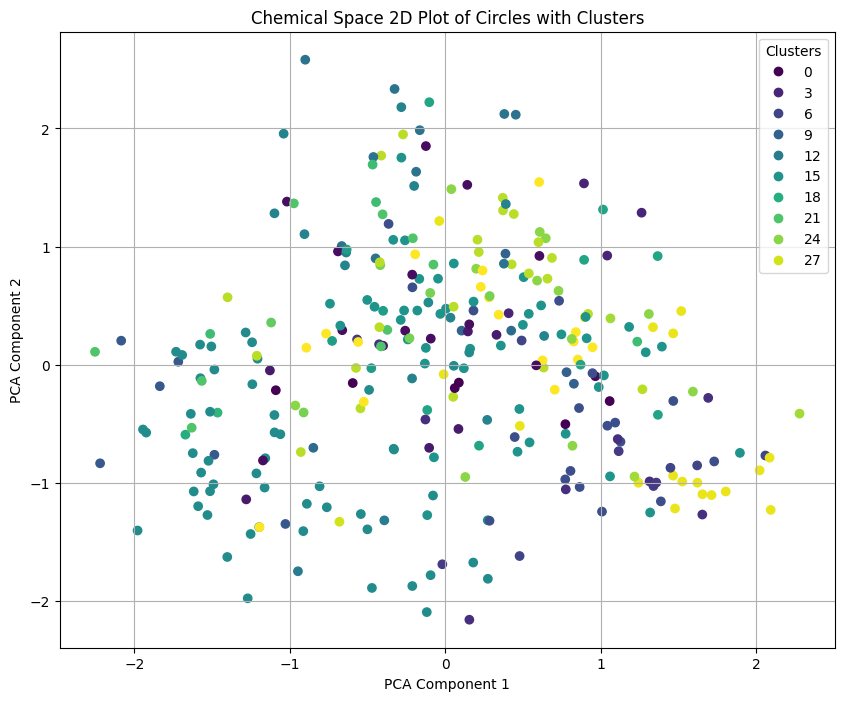

In [ ]:
plot_circles1(df10_mol1, 30)

Number of circles: 686


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


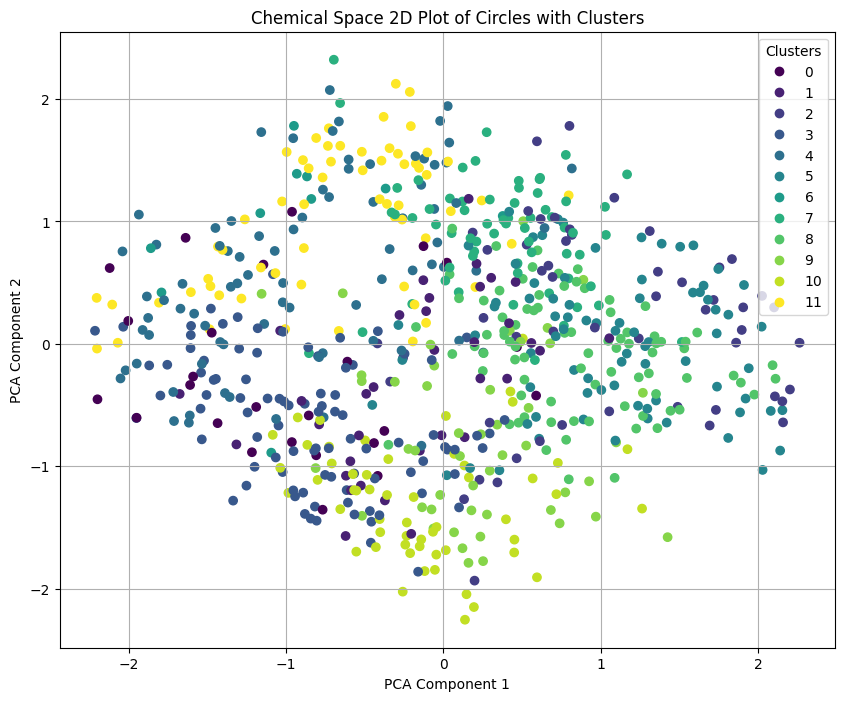

In [ ]:
plot_circles1(df50_mol1, 12)

Number of circles: 667


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


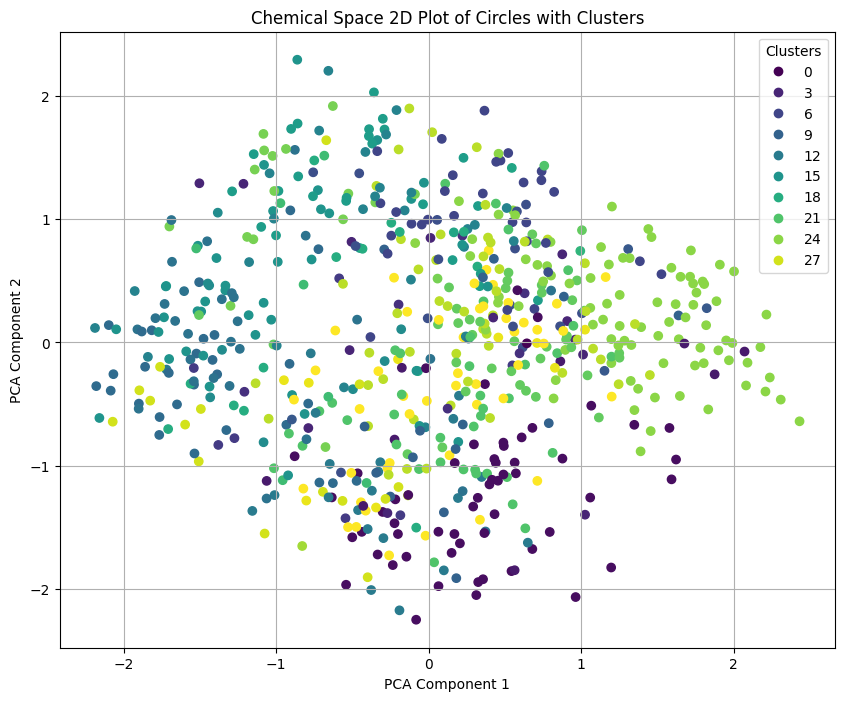

In [ ]:
plot_circles1(df50_mol1, 30)

Number of circles: 315


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


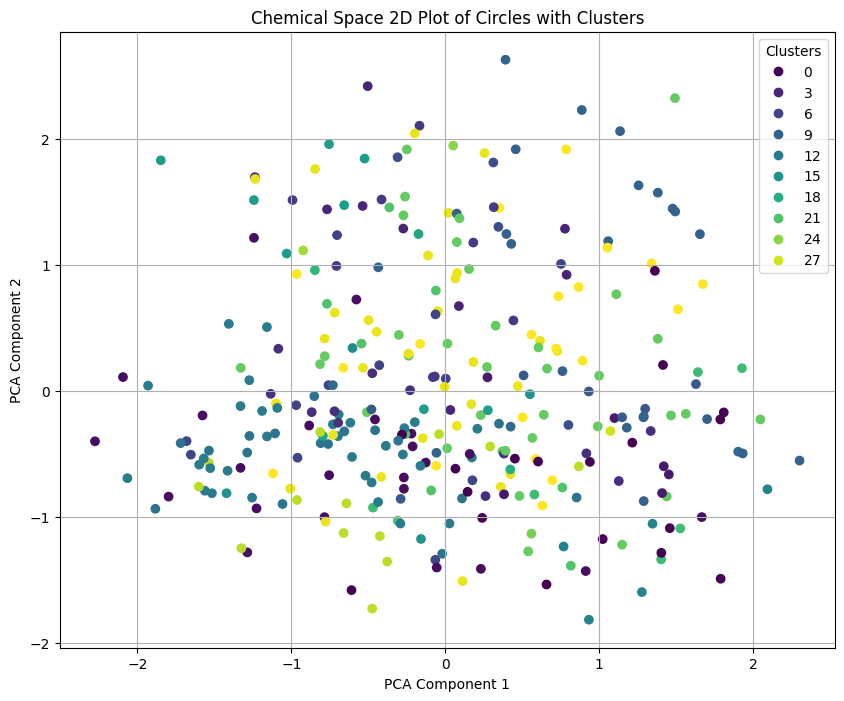

In [ ]:
plot_circles1(df_mol1, 30)

In [ ]:
len50, vec50 = get_ncircle1(df50_mol)

In [ ]:
vecs_array50 = np.array([bitvect_to_list(fp) for fp in vec50])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

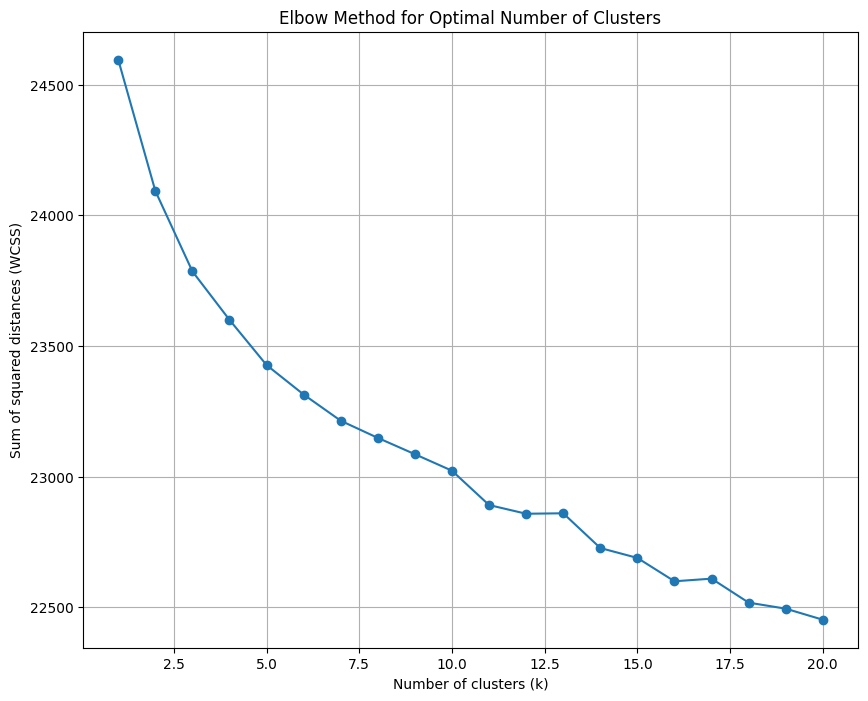

In [ ]:
elbow_method(vecs_array50, 20)

In [ ]:
len, vec = get_ncircle1(df_mol)

In [ ]:
vecs_array = np.array([bitvect_to_list(fp) for fp in vec])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

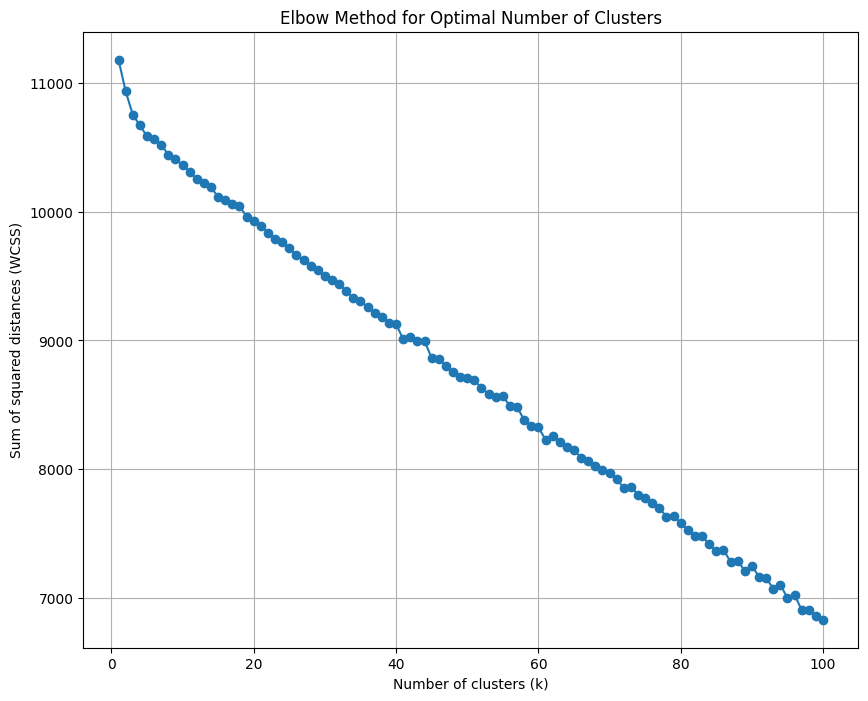

In [ ]:
elbow_method(vecs_array, 100)